In [1]:
import geopandas as gpd
import pandas as pd

samples = pd.read_parquet('global_samples_v20240210.pq')
samples = gpd.GeoDataFrame(samples, geometry=gpd.points_from_xy(samples['x'], samples['y']))
samples = samples.set_crs('EPSG:4326')
samples['year'] =samples['ref_date'].dt.year
samples

/tmp/ipykernel_3794423/2474016542.py:1: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


,class,x,y,class_pct,vi_tile_id,imagery,index_right,glad_tile_id,ref_date,geometry,year
0,2,22.553534,15.884310,94,1139,Google,13283.0,022E_15N,2000-02-22,POINT (22.55353 15.88431),2000
1,2,22.554033,15.884310,31,1139,Google,13283.0,022E_15N,2000-02-22,POINT (22.55403 15.88431),2000
2,2,22.554533,15.884310,47,1139,Google,13283.0,022E_15N,2000-02-22,POINT (22.55453 15.88431),2000
3,2,22.555035,15.884310,28,1139,Google,13283.0,022E_15N,2000-02-22,POINT (22.55504 15.88431),2000
4,2,22.555534,15.884310,6,1139,Google,13283.0,022E_15N,2000-02-22,POINT (22.55553 15.88431),2000
...,...,...,...,...,...,...,...,...,...,...,...
261,2,-95.081860,52.580067,97,6086,Google,6586.0,095W_52N,2013-05-22,POINT (-95.08186 52.58007),2013
262,2,-95.081360,52.580067,69,6086,Google,6586.0,095W_52N,2013-05-22,POINT (-95.08136 52.58007),2013
263,2,-95.080864,52.580067,92,6086,Google,6586.0,095W_52N,2013-05-22,POINT (-95.08086 52.58007),2013
264,2,-95.080360,52.580067,100,6086,Google,6586.0,095W_52N,2013-05-22,POINT (-95.08036 52.58007),2013


In [2]:
samples.groupby(['vi_tile_id','class']).size().reset_index()

,vi_tile_id,class,0
0,1-mvp,2,101
1,1-mvp,3,239
2,10,2,504
3,10,3,88
4,10-mvp,2,130
...,...,...,...
13528,9419,3,182
13529,9420,3,196
13530,9423,3,234
13531,9425,1,5


## Interpolates samples (Google / Bing)

In [3]:
from skmap import parallel

def _new_samples(rows):
    two_dts = (len(rows['imagery'].unique()) == 2)
    if two_dts:
        new_samp = rows[rows['imagery'] == 'Google'].merge(rows[rows['imagery'] == 'Bing'], on=['x','y','class','class_pct'], suffixes=('', '_y'))[list(samples.columns) + ['year_y'] ].rename(columns={'year':'start_year', 'year_y': 'end_year'})
        if (new_samp.shape[0] > 0):
            r = new_samp.iloc[0]
            if (r['start_year'] > r['end_year']):
                new_samp = new_samp.rename(columns={'start_year':'end_year', 'end_year': 'start_year'})
        return new_samp
    return None

new_samples = []
args = [ (rows,) for tile_id, rows in samples.groupby(['vi_tile_id']) ]

In [4]:
for new_samp in parallel.job(_new_samples, args, n_jobs=96,  joblib_args={'backend': 'multiprocessing'}):
    if new_samp is not None:
        new_samples.append(new_samp)

new_samples = pd.concat(new_samples)
new_samples

,class,x,y,class_pct,vi_tile_id,imagery,index_right,glad_tile_id,ref_date,geometry,end_year,start_year
0,3,29.627228,64.837630,100,1-mvp,Google,3611.0,029E_64N,2018-07-10,POINT (29.62723 64.83763),2018,2010
1,3,29.627728,64.837630,92,1-mvp,Google,3611.0,029E_64N,2018-07-10,POINT (29.62773 64.83763),2018,2010
2,3,29.630228,64.837630,100,1-mvp,Google,3611.0,029E_64N,2018-07-10,POINT (29.63023 64.83763),2018,2010
3,3,29.630728,64.837630,100,1-mvp,Google,3611.0,029E_64N,2018-07-10,POINT (29.63073 64.83763),2018,2010
4,3,29.632229,64.837630,100,1-mvp,Google,3611.0,029E_64N,2018-07-10,POINT (29.63223 64.83763),2018,2010
...,...,...,...,...,...,...,...,...,...,...,...,...
151,3,96.931110,28.773851,100,9417,Google,11420.0,096E_28N,2012-11-02,POINT (96.93111 28.77385),2013,2012
152,3,96.931610,28.773851,100,9417,Google,11420.0,096E_28N,2012-11-02,POINT (96.93161 28.77385),2013,2012
153,3,96.932106,28.773851,100,9417,Google,11420.0,096E_28N,2012-11-02,POINT (96.93211 28.77385),2013,2012
154,3,96.932610,28.773851,100,9417,Google,11420.0,096E_28N,2012-11-02,POINT (96.93261 28.77385),2013,2012


In [5]:
import numpy as np
new_samples['diff_year'] = new_samples['end_year'] - new_samples['start_year']
new_samples_sel = new_samples[np.logical_and(new_samples['diff_year'] > 1, new_samples['diff_year'] <= 4)]
new_samples_sel

,class,x,y,class_pct,vi_tile_id,imagery,index_right,glad_tile_id,ref_date,geometry,end_year,start_year,diff_year
0,2,48.394176,48.275646,100,100,Google,7605.0,048E_48N,2007-05-30,POINT (48.39418 48.27565),2011,2007,4
1,2,48.397675,48.275646,100,100,Google,7605.0,048E_48N,2007-05-30,POINT (48.39767 48.27565),2011,2007,4
2,2,48.400177,48.275646,100,100,Google,7605.0,048E_48N,2007-05-30,POINT (48.40018 48.27565),2011,2007,4
3,2,48.400677,48.275646,100,100,Google,7605.0,048E_48N,2007-05-30,POINT (48.40068 48.27565),2011,2007,4
4,2,48.401176,48.275646,100,100,Google,7605.0,048E_48N,2007-05-30,POINT (48.40118 48.27565),2011,2007,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,3,103.358240,28.307026,100,9398,Google,11427.0,103E_28N,2016-07-19,POINT (103.35824 28.30703),2016,2012,4
117,3,103.358740,28.307026,100,9398,Google,11427.0,103E_28N,2016-07-19,POINT (103.35874 28.30703),2016,2012,4
118,3,103.359240,28.307026,100,9398,Google,11427.0,103E_28N,2016-07-19,POINT (103.35924 28.30703),2016,2012,4
119,3,103.359740,28.307026,100,9398,Google,11427.0,103E_28N,2016-07-19,POINT (103.35974 28.30703),2016,2012,4


In [6]:
rep_samples = []
for nyears, rows in new_samples_sel.groupby(['diff_year']):
    for i in range(1,nyears[0]):
        r = pd.DataFrame(rows)
        r['year'] = r['start_year'] + i
        r = r.drop(columns=['end_year','start_year','diff_year'])
        rep_samples.append(r)

rep_samples = pd.concat(rep_samples)
rep_samples['imagery'] = 'Google / Bing'
rep_samples

,class,x,y,class_pct,vi_tile_id,imagery,index_right,glad_tile_id,ref_date,geometry,year
0,3,-78.30158,41.811874,100,1006-mvp,Google / Bing,9004.0,078W_41N,2022-10-04,POINT (-78.30158 41.81187),2021
1,3,-78.30109,41.811874,100,1006-mvp,Google / Bing,9004.0,078W_41N,2022-10-04,POINT (-78.30109 41.81187),2021
2,3,-78.30058,41.811874,100,1006-mvp,Google / Bing,9004.0,078W_41N,2022-10-04,POINT (-78.30058 41.81187),2021
3,3,-78.30009,41.811874,100,1006-mvp,Google / Bing,9004.0,078W_41N,2022-10-04,POINT (-78.30009 41.81187),2021
4,3,-78.29958,41.811874,100,1006-mvp,Google / Bing,9004.0,078W_41N,2022-10-04,POINT (-78.29958 41.81187),2021
...,...,...,...,...,...,...,...,...,...,...,...
116,3,103.35824,28.307026,100,9398,Google / Bing,11427.0,103E_28N,2016-07-19,POINT (103.35824 28.30703),2015
117,3,103.35874,28.307026,100,9398,Google / Bing,11427.0,103E_28N,2016-07-19,POINT (103.35874 28.30703),2015
118,3,103.35924,28.307026,100,9398,Google / Bing,11427.0,103E_28N,2016-07-19,POINT (103.35924 28.30703),2015
119,3,103.35974,28.307026,100,9398,Google / Bing,11427.0,103E_28N,2016-07-19,POINT (103.35974 28.30703),2015


In [7]:
sample_bkp = pd.DataFrame(samples)

In [8]:
samples = pd.concat([samples, rep_samples]).reset_index(drop=True)

In [9]:
samples[samples['class_pct'] >= 100]

,class,x,y,class_pct,vi_tile_id,imagery,index_right,glad_tile_id,ref_date,geometry,year
6,2,22.556534,15.884310,100,1139,Google,13283.0,022E_15N,2000-02-22,POINT (22.55653 15.88431),2000
7,2,22.557034,15.884310,100,1139,Google,13283.0,022E_15N,2000-02-22,POINT (22.55703 15.88431),2000
11,2,22.559034,15.884310,100,1139,Google,13283.0,022E_15N,2000-02-22,POINT (22.55903 15.88431),2000
19,2,22.556034,15.883810,100,1139,Google,13283.0,022E_15N,2000-02-22,POINT (22.55603 15.88381),2000
20,2,22.556534,15.883810,100,1139,Google,13283.0,022E_15N,2000-02-22,POINT (22.55653 15.88381),2000
...,...,...,...,...,...,...,...,...,...,...,...
3663613,3,103.358240,28.307026,100,9398,Google / Bing,11427.0,103E_28N,2016-07-19,POINT (103.35824 28.30703),2015
3663614,3,103.358740,28.307026,100,9398,Google / Bing,11427.0,103E_28N,2016-07-19,POINT (103.35874 28.30703),2015
3663615,3,103.359240,28.307026,100,9398,Google / Bing,11427.0,103E_28N,2016-07-19,POINT (103.35924 28.30703),2015
3663616,3,103.359740,28.307026,100,9398,Google / Bing,11427.0,103E_28N,2016-07-19,POINT (103.35974 28.30703),2015


In [10]:
import seaborn as sns
sns.set_theme(context='talk', style="whitegrid")

<Axes: xlabel='year', ylabel='Number of samples (log scale)'>

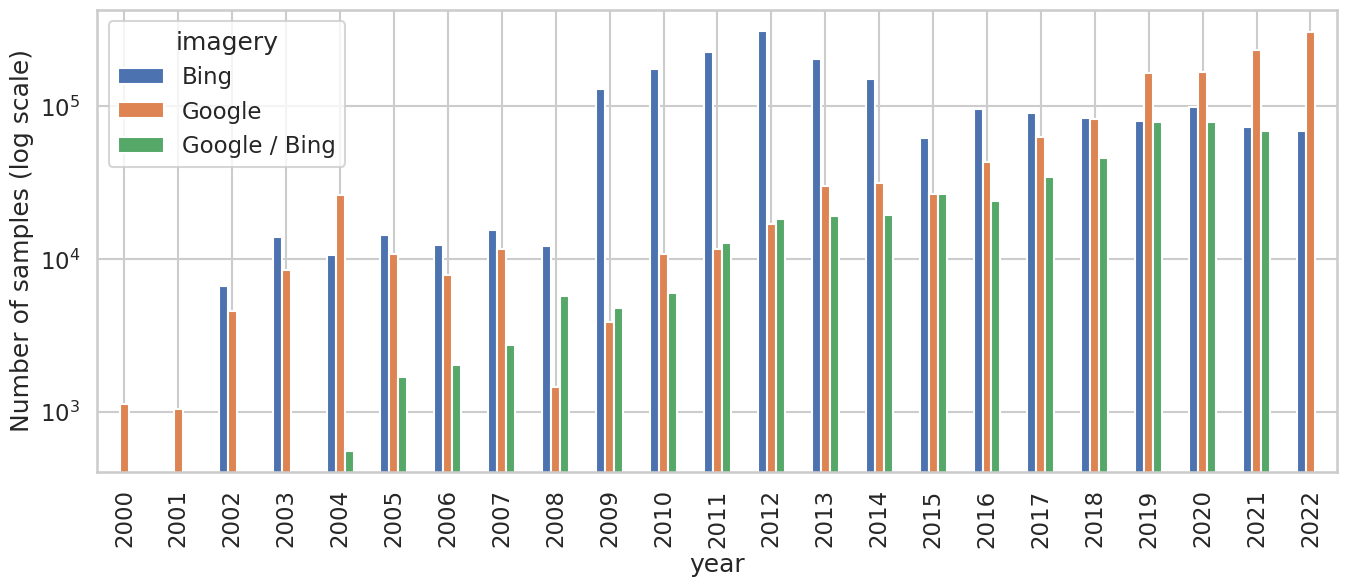

In [11]:
samples[['year', 'imagery']].value_counts().unstack(fill_value=0).plot(kind='bar', ylabel='Number of samples (log scale)', figsize=(16,6), logy=True)

In [12]:
len(samples['vi_tile_id'].unique())

7145

In [13]:
samples['class_label'] = samples['class'].map({1 : 'Seed grass', 2 : 'Natural / Semi-natural grass', 3: 'Not-grass'})

<Axes: xlabel='year', ylabel='Number of samples (log scale)'>

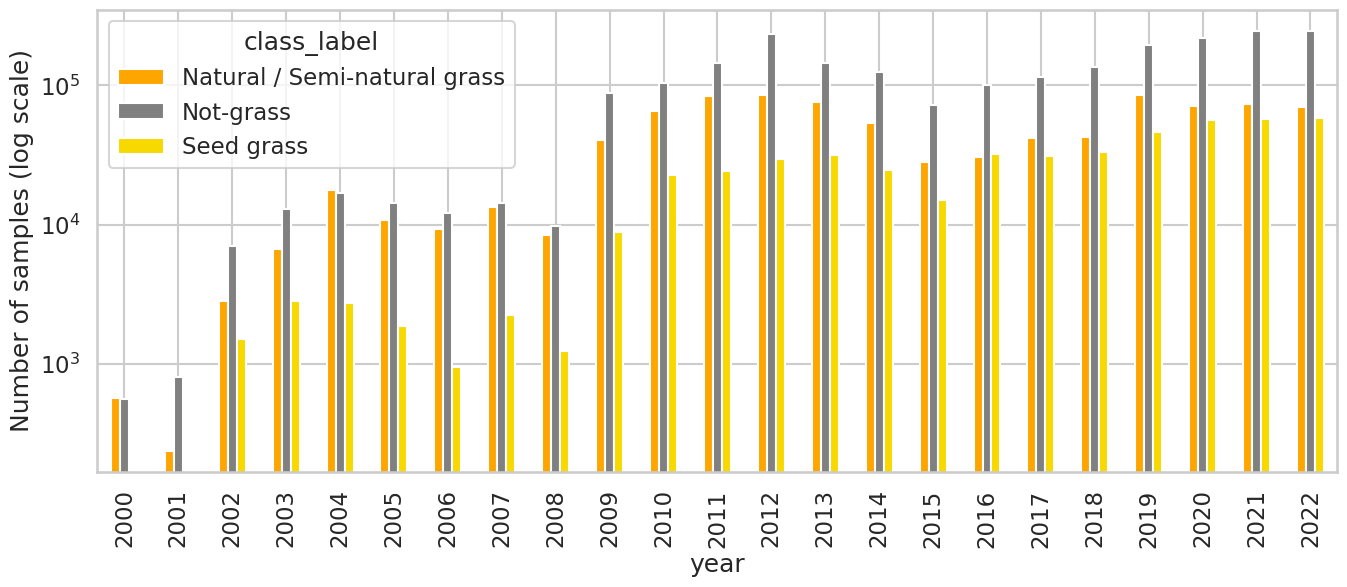

In [14]:
samples[['year', 'class_label']].value_counts().unstack(fill_value=0).plot(kind='bar', ylabel='Number of samples (log scale)', figsize=(16,6), logy=True, 
                                                                        color = ['orange','gray','#f7d900'])

<Axes: ylabel='class'>

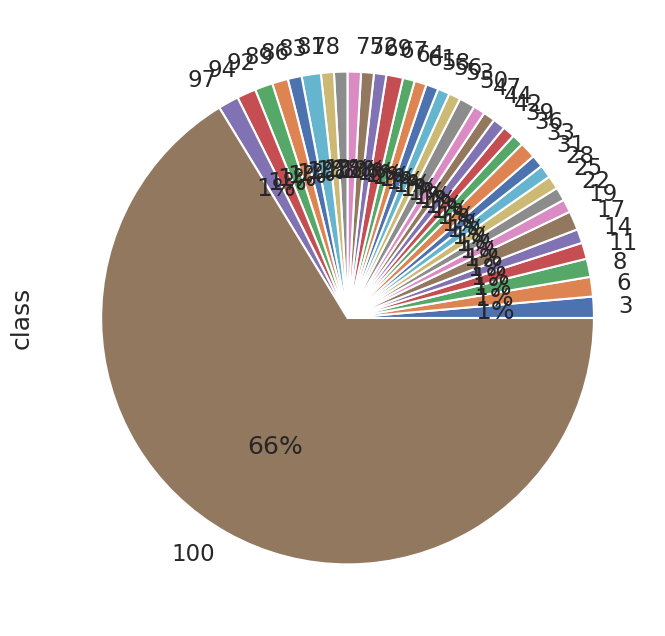

In [15]:
samples.groupby(['class_pct']).count().plot(kind='pie', y='class', autopct='%1.0f%%', figsize=(8,8), legend=False)

In [231]:
samples.groupby(['class_label']).count().plot(kind='pie', y='class', autopct='%1.0f%%', figsize=(10,10), colors = ['orange','gray','#f7d900'], legend=False)

KeyError: 'class'

In [38]:
samples.to_parquet('global_samples_v20240210_interp.pq')

## Harmonized samples

In [3]:
import pandas as pd
db = pd.read_parquet('db_data_harmo.parquet')
db

,dataset_name,reference_year,original_lulc_class,gpw_lulc_class,sample_weight,observation,geometry
0,Mapbiomes,1985,Grassland formation,Natural and Semi-natural grass,157707.894211,None,b'\x01\x01\x00\x00\x00\xf1Fj\xca\xe3\xfdM\xc05...
1,Mapbiomes,1985,Other,Other,333.480062,None,"b'\x01\x01\x00\x00\x00\xe3d,\xe4\xdb\x07N\xc0l..."
2,Mapbiomes,1985,Pasture,Seeded grass,137744.732033,None,b'\x01\x01\x00\x00\x00\xf0]\xd6\x06\x9fpN\xc0\...
3,Mapbiomes,1985,Pasture,Seeded grass,140649.430403,None,b'\x01\x01\x00\x00\x00eX\x83\xffFsN\xc0*Am\xbe...
4,Mapbiomes,1985,Savanna formation,Other,140649.430403,None,b'\x01\x01\x00\x00\x00\xcd\x96\x8b|\x07\x02N\x...
...,...,...,...,...,...,...,...
21385002,GLanCE,2018,Grassland,Seeded grass,3.000000,,b'\x01\x01\x00\x00\x00\x1f!\x19J\xac\xc8$@=\xf...
21385003,GLanCE,2018,Grassland,Seeded grass,3.000000,,"b'\x01\x01\x00\x00\x00\x95\x07\xd5\x96^\xf5""@ ..."
21385004,GLanCE,2018,Grassland,Seeded grass,3.000000,,b'\x01\x01\x00\x00\x00\xf66w#5_#@\x07S\xe0+\xf...
21385005,GLanCE,2018,Grassland,Seeded grass,3.000000,,"b'\x01\x01\x00\x00\x00^\xcb""\x1d_\xe7#@\xb2\x9..."


In [21]:
import geopandas as gpd
import numpy as np
samp_harm = db[db['dataset_name'].isin(['Cropharvest', 'Predicts'])]
samp_harm = gpd.GeoDataFrame(samp_harm, geometry=gpd.GeoSeries.from_wkb(samp_harm['geometry']))
samp_harm = samp_harm.set_crs('EPSG:4326')
samp_harm['reference_year'] = samp_harm['reference_year'].astype(int)
samp_harm = samp_harm[np.logical_and(samp_harm['reference_year'] >= 2000, samp_harm['reference_year'] <= 2022)]
samp_harm

,dataset_name,reference_year,original_lulc_class,gpw_lulc_class,sample_weight,observation,geometry
5106945,Predicts,2005,Primary vegetation,Other,1.0,None,POINT (-84.07327 10.44722)
5106946,Predicts,2005,Primary vegetation,Other,1.0,None,POINT (-84.09147 10.43805)
5106947,Predicts,2005,Pasture,Seeded grass,1.0,None,POINT (-83.88995 10.35860)
5106948,Predicts,2005,Pasture,Seeded grass,1.0,None,POINT (-83.88978 10.34052)
5106949,Predicts,2001,Primary vegetation,Other,1.0,None,POINT (172.46708 -42.49879)
...,...,...,...,...,...,...,...
5285223,Cropharvest,2019,lentils,Crops and other related agricultural practices,1.0,None,POINT (-126.22823 53.83087)
5285224,Cropharvest,2019,lentils,Crops and other related agricultural practices,1.0,None,POINT (-119.90283 56.21562)
5285225,Cropharvest,2019,lentils,Crops and other related agricultural practices,1.0,None,POINT (-119.90277 56.21327)
5285226,Cropharvest,2020,quinoa,Crops and other related agricultural practices,1.0,None,POINT (-80.49501 43.13073)


In [27]:
db_harmo = pd.read_parquet('db_data_harmo_WorldCereal.parquet')

In [38]:
samp_harm_2[samp_harm_2['reference_year'] != 'None']['reference_year'].value_counts()

reference_year
2019    10842688
2020    10570328
2017     9997500
2021     6010972
2018      719823
2016      122593
2022         598
Name: count, dtype: int64

In [39]:
import geopandas as gpd
import numpy as np
samp_harm_2 = db_harmo[db_harmo['dataset_name'].isin(['WorldCereal'])]
samp_harm_2 = gpd.GeoDataFrame(samp_harm_2, geometry=gpd.GeoSeries.from_wkb(samp_harm_2['geometry']))
samp_harm_2 = samp_harm_2.set_crs('EPSG:4326')
samp_harm_2 = samp_harm_2[samp_harm_2['reference_year'] != 'None']
samp_harm_2['reference_year'] = samp_harm_2['reference_year'].astype(int)
samp_harm_2 = samp_harm_2[np.logical_and(samp_harm_2['reference_year'] >= 2000, samp_harm_2['reference_year'] <= 2022)]
samp_harm_2 = samp_harm_2[samp_harm_2['sample_weight'] == 1]
samp_harm_2

,dataset_name,reference_year,original_lulc_class,gpw_lulc_class,sample_weight,observation,geometry
0,WorldCereal,2016,Grassland *,Seeded grass,1,2016_CAN_AAFC-ACIGTD_POINT_1100,POINT (-75.71288 45.38695)
1,WorldCereal,2016,Grassland *,Seeded grass,1,2016_CAN_AAFC-ACIGTD_POINT_1101,POINT (-75.67572 45.41663)
2,WorldCereal,2016,Annual cropland,Crops and other related agricultural practices,1,2016_CAN_AAFC-ACIGTD_POINT_1102,POINT (-75.59615 45.40957)
3,WorldCereal,2016,Annual cropland,Crops and other related agricultural practices,1,2016_CAN_AAFC-ACIGTD_POINT_1103,POINT (-75.59426 45.40976)
4,WorldCereal,2016,Annual cropland,Crops and other related agricultural practices,1,2016_CAN_AAFC-ACIGTD_POINT_1104,POINT (-75.55407 45.37412)
...,...,...,...,...,...,...,...
38265300,WorldCereal,2018,Annual cropland,Crops and other related agricultural practices,1,2018_TZ_AFSIS_POINT_1102338,POINT (34.54339 -1.51615)
38265304,WorldCereal,2018,Annual cropland,Crops and other related agricultural practices,1,2018_TZ_AFSIS_POINT_1102342,POINT (34.51628 -1.57413)
38265306,WorldCereal,2018,Annual cropland,Crops and other related agricultural practices,1,2018_TZ_AFSIS_POINT_1102344,POINT (34.47324 -1.60943)
38265307,WorldCereal,2018,Annual cropland,Crops and other related agricultural practices,1,2018_TZ_AFSIS_POINT_1102345,POINT (34.48005 -1.59156)


In [47]:
samp_harm_2 = samp_harm_2.sample(int(samp_harm_2.shape[0] * 0.1), random_state=1989)
samp_harm_2

,dataset_name,reference_year,original_lulc_class,gpw_lulc_class,sample_weight,observation,geometry
3010627,WorldCereal,2017,Perennial cropland,Crops and other related agricultural practices,1,fr2017lpis5341563,POINT (-0.25042 47.10527)
4324769,WorldCereal,2017,Grassland *,Seeded grass,1,fr2017lpis10947673,POINT (0.01822 42.84990)
9640205,WorldCereal,2018,Grassland *,Seeded grass,1,000028065E7DC34E,POINT (4.20059 51.09503)
25919218,WorldCereal,2020,Perennial cropland,Crops and other related agricultural practices,1,fr2020lpis2515925,POINT (5.15940 44.32925)
33320850,WorldCereal,2021,Annual cropland,Crops and other related agricultural practices,1,DE_NRW_2021_EC21_4991336,POINT (6.32129 51.09997)
...,...,...,...,...,...,...,...
6354037,WorldCereal,2017,Grassland *,Seeded grass,1,fr2017lpis859267,POINT (2.48193 44.57949)
29807290,WorldCereal,2020,Grassland *,Seeded grass,1,fr2020lpis14456046,POINT (1.18220 45.32974)
30993186,WorldCereal,2020,Grassland *,Seeded grass,1,fr2020lpis18571956,POINT (1.82690 44.13552)
31545821,WorldCereal,2021,Annual cropland,Crops and other related agricultural practices,1,2021_BE_Flanders_full_2194526986,POINT (3.10123 50.98213)


In [50]:
samp_harm_f = pd.concat([samp_harm, samp_harm_2])
samp_harm_f['x'] = samp_harm_f.geometry.x
samp_harm_f['y'] = samp_harm_f.geometry.y
samp_harm_f['ref_date'] = pd.to_datetime(samp_harm_f['reference_year'],format='%Y')
samp_harm_f = samp_harm_f.sjoin(tiles[['TILE','geometry']], how="left")
samp_harm_f

,dataset_name,reference_year,original_lulc_class,gpw_lulc_class,sample_weight,observation,geometry,x,y
5106945,Predicts,2005,Primary vegetation,Other,1.0,None,POINT (-84.07327 10.44722),-84.073274,10.447222
5106946,Predicts,2005,Primary vegetation,Other,1.0,None,POINT (-84.09147 10.43805),-84.091468,10.438046
5106947,Predicts,2005,Pasture,Seeded grass,1.0,None,POINT (-83.88995 10.35860),-83.889946,10.358602
5106948,Predicts,2005,Pasture,Seeded grass,1.0,None,POINT (-83.88978 10.34052),-83.889780,10.340521
5106949,Predicts,2001,Primary vegetation,Other,1.0,None,POINT (172.46708 -42.49879),172.467078,-42.498792
...,...,...,...,...,...,...,...,...,...
6354037,WorldCereal,2017,Grassland *,Seeded grass,1.0,fr2017lpis859267,POINT (2.48193 44.57949),2.481927,44.579494
29807290,WorldCereal,2020,Grassland *,Seeded grass,1.0,fr2020lpis14456046,POINT (1.18220 45.32974),1.182200,45.329741
30993186,WorldCereal,2020,Grassland *,Seeded grass,1.0,fr2020lpis18571956,POINT (1.82690 44.13552),1.826901,44.135519
31545821,WorldCereal,2021,Annual cropland,Crops and other related agricultural practices,1.0,2021_BE_Flanders_full_2194526986,POINT (3.10123 50.98213),3.101227,50.982126


In [ ]:
tiles = gpd.read_file('ard2_final_status.gpkg')

In [53]:
samp_harm_f = samp_harm_f.rename(columns={'TILE':'glad_tile_id'})
samp_harm_f

,dataset_name,reference_year,original_lulc_class,gpw_lulc_class,sample_weight,observation,geometry,x,y,index_right,glad_tile_id
5106945,Predicts,2005,Primary vegetation,Other,1.0,None,POINT (-84.07327 10.44722),-84.073274,10.447222,13776.0,084W_10N
5106946,Predicts,2005,Primary vegetation,Other,1.0,None,POINT (-84.09147 10.43805),-84.091468,10.438046,13776.0,084W_10N
5106947,Predicts,2005,Pasture,Seeded grass,1.0,None,POINT (-83.88995 10.35860),-83.889946,10.358602,13777.0,083W_10N
5106948,Predicts,2005,Pasture,Seeded grass,1.0,None,POINT (-83.88978 10.34052),-83.889780,10.340521,13777.0,083W_10N
5106949,Predicts,2001,Primary vegetation,Other,1.0,None,POINT (172.46708 -42.49879),172.467078,-42.498792,18512.0,172E_42S
...,...,...,...,...,...,...,...,...,...,...,...
6354037,WorldCereal,2017,Grassland *,Seeded grass,1.0,fr2017lpis859267,POINT (2.48193 44.57949),2.481927,44.579494,8426.0,002E_44N
29807290,WorldCereal,2020,Grassland *,Seeded grass,1.0,fr2020lpis14456046,POINT (1.18220 45.32974),1.182200,45.329741,8215.0,001E_45N
30993186,WorldCereal,2020,Grassland *,Seeded grass,1.0,fr2020lpis18571956,POINT (1.82690 44.13552),1.826901,44.135519,8425.0,001E_44N
31545821,WorldCereal,2021,Annual cropland,Crops and other related agricultural practices,1.0,2021_BE_Flanders_full_2194526986,POINT (3.10123 50.98213),3.101227,50.982126,7114.0,003E_50N


In [62]:
len(samp_harm_f['glad_tile_id'].unique())

2536

In [61]:
samp_harm_f[['x', 'y','dataset_name','ref_date','reference_year','original_lulc_class','gpw_lulc_class','sample_weight','observation','glad_tile_id']].to_parquet('global_samples_v20240210_harm.pq')

In [24]:
import geopandas as gpd
import pandas as pd

samples = pd.read_parquet('global_samples_v20240210_interp.pq')
samples

,class,x,y,class_pct,vi_tile_id,imagery,index_right,glad_tile_id,ref_date,geometry,year,class_label
0,2,22.553534,15.884310,94,1139,Google,13283.0,022E_15N,2000-02-22,b'\x01\x01\x00\x00\x00\\9{g\xb4\x8d6@0\r\xc3G\...,2000,Natural / Semi-natural grass
1,2,22.554033,15.884310,31,1139,Google,13283.0,022E_15N,2000-02-22,b'\x01\x01\x00\x00\x00\x9f\xe7O\x1b\xd5\x8d6@0...,2000,Natural / Semi-natural grass
2,2,22.554533,15.884310,47,1139,Google,13283.0,022E_15N,2000-02-22,b'\x01\x01\x00\x00\x00\x82\x8d\xeb\xdf\xf5\x8d...,2000,Natural / Semi-natural grass
3,2,22.555035,15.884310,28,1139,Google,13283.0,022E_15N,2000-02-22,"b'\x01\x01\x00\x00\x00\xa7""\x15\xc6\x16\x8e6@0...",2000,Natural / Semi-natural grass
4,2,22.555534,15.884310,6,1139,Google,13283.0,022E_15N,2000-02-22,b'\x01\x01\x00\x00\x00\xea\xd0\xe9y7\x8e6@0\r\...,2000,Natural / Semi-natural grass
...,...,...,...,...,...,...,...,...,...,...,...,...
3663613,3,103.358240,28.307026,100,9398,Google / Bing,11427.0,103E_28N,2016-07-19,b'\x01\x01\x00\x00\x00\x9e\x07wg\xed\xd6Y@\x8e...,2015,Not-grass
3663614,3,103.358740,28.307026,100,9398,Google / Bing,11427.0,103E_28N,2016-07-19,b'\x01\x01\x00\x00\x00\x17\xf1\x9d\x98\xf5\xd6...,2015,Not-grass
3663615,3,103.359240,28.307026,100,9398,Google / Bing,11427.0,103E_28N,2016-07-19,b'\x01\x01\x00\x00\x00\x90\xda\xc4\xc9\xfd\xd6...,2015,Not-grass
3663616,3,103.359740,28.307026,100,9398,Google / Bing,11427.0,103E_28N,2016-07-19,b'\x01\x01\x00\x00\x00\t\xc4\xeb\xfa\x05\xd7Y@...,2015,Not-grass


In [26]:
len(samples['glad_tile_id'].unique())

5214

In [2]:
import geopandas as gpd
tiles = gpd.read_file('ard2_final_status.gpkg')
tiles

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


,X_COORD,Y_COORD,TILE,n_images,geometry
0,-77.5,83.5,077W_83N,598,"MULTIPOLYGON (((-78.00000 84.00000, -77.00000 ..."
1,-76.5,83.5,076W_83N,598,"MULTIPOLYGON (((-77.00000 84.00000, -76.00000 ..."
2,-75.5,83.5,075W_83N,598,"MULTIPOLYGON (((-76.00000 84.00000, -75.00000 ..."
3,-74.5,83.5,074W_83N,598,"MULTIPOLYGON (((-75.00000 84.00000, -74.00000 ..."
4,-73.5,83.5,073W_83N,598,"MULTIPOLYGON (((-74.00000 84.00000, -73.00000 ..."
...,...,...,...,...,...
18662,-70.5,-55.5,070W_55S,598,"MULTIPOLYGON (((-71.00000 -55.00000, -70.00000..."
18663,-69.5,-55.5,069W_55S,598,"MULTIPOLYGON (((-70.00000 -55.00000, -69.00000..."
18664,-68.5,-55.5,068W_55S,598,"MULTIPOLYGON (((-69.00000 -55.00000, -68.00000..."
18665,-67.5,-55.5,067W_55S,598,"MULTIPOLYGON (((-68.00000 -55.00000, -67.00000..."


In [3]:
from skmap.misc import find_files

static_raster = find_files('./static', '*.vrt')
args = []

for glad_tile_id, rows in samples.groupby('glad_tile_id'):
    bounds = tiles[tiles['TILE'] == glad_tile_id].iloc[0].geometry.bounds
    args.append((glad_tile_id, rows, static_raster, bounds))

In [4]:
from skmap.mapper import SpaceOverlay, SpaceTimeOverlay
from skmap import parallel 
from skmap.misc import vrt_warp

def _raster_files(tile, bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermal'], base_url='http://192.168.1.30:8333'):
    result = []
    
    for band in bands:
        result += [
            f'{base_url}/prod-landsat-ard2/{tile}/seasconv/{band}_glad.SeasConv.ard2_m_30m_s_' + '{year}0101_{year}0228_go_epsg.4326_v20230908.tif',
            f'{base_url}/prod-landsat-ard2/{tile}/seasconv/{band}_glad.SeasConv.ard2_m_30m_s_' + '{year}0301_{year}0430_go_epsg.4326_v20230908.tif',
            f'{base_url}/prod-landsat-ard2/{tile}/seasconv/{band}_glad.SeasConv.ard2_m_30m_s_' + '{year}0501_{year}0630_go_epsg.4326_v20230908.tif',
            f'{base_url}/prod-landsat-ard2/{tile}/seasconv/{band}_glad.SeasConv.ard2_m_30m_s_' + '{year}0701_{year}0831_go_epsg.4326_v20230908.tif',
            f'{base_url}/prod-landsat-ard2/{tile}/seasconv/{band}_glad.SeasConv.ard2_m_30m_s_' + '{year}0901_{year}1031_go_epsg.4326_v20230908.tif',
            f'{base_url}/prod-landsat-ard2/{tile}/seasconv/{band}_glad.SeasConv.ard2_m_30m_s_' + '{year}1101_{year}1231_go_epsg.4326_v20230908.tif'
        ]
    
    return result

def overlay(glad_tile_id, rows, static_raster, bounds):
    landsat_files = _raster_files(glad_tile_id)
    spt_overlay = SpaceTimeOverlay(rows, 'ref_date', landsat_files, verbose=False)
    spt_result = spt_overlay.run()
    
    vrt_files = vrt_warp(static_raster, dst_crs='EPSG:4326', tr=0.00025, te = bounds)
    spc_overlay = SpaceOverlay(spt_result, vrt_files, verbose=False)
    spc_result = spc_overlay.run()
    dummy = [ os.unlink(f) for f in vrt_files ]
    
    return spc_result

result = []
for df in parallel.job(overlay, args[0:10], n_jobs=10):
    result.append(df)

AttributeError: 'DataFrame' object has no attribute 'startswith'

In [37]:
result

[]

In [ ]:
result = pd.concat(result)
result

## Data preparation

In [193]:
import geopandas as gpd
import pandas as pd

samples_gpw = pd.read_parquet('global_samples_v20240210_interp_overlaid.pq').reset_index(drop=True)
samples_gpw['cv_group'] = 'gpw_' + samples_gpw['vi_tile_id']
samples_gpw['dataset_name'] = 'GPW'
samples_gpw

,class,x,y,class_pct,vi_tile_id,imagery,index_right,glad_tile_id,ref_date,year,...,wv_mcd19a2v061.seasconv.m.m07_sd_1km_s_20000101_20221231_go_epsg.4326_v20230619,wv_mcd19a2v061.seasconv.m.m12_sd_1km_s_20000101_20221231_go_epsg.4326_v20230619,wv_mcd19a2v061.seasconv.m.m09_p50_1km_s_20000101_20221231_go_epsg.4326_v20230619,wv_mcd19a2v061.seasconv.m.m12_p50_1km_s_20000101_20221231_go_epsg.4326_v20230619,wv_mcd19a2v061.seasconv.m.m10_sd_1km_s_20000101_20221231_go_epsg.4326_v20230619,wv_mcd19a2v061.seasconv.m.m09_sd_1km_s_20000101_20221231_go_epsg.4326_v20230619,wv_mcd19a2v061.seasconv.m.m11_sd_1km_s_20000101_20221231_go_epsg.4326_v20230619,wv_mcd19a2v061.seasconv.m.m11_p50_1km_s_20000101_20221231_go_epsg.4326_v20230619,cv_group,dataset_name
0,3,0.452821,6.793882,39,8322,Bing,14261.0,000E_06N,2014-01-03,2014,...,381.0,287.0,4289.0,2736.0,348.0,446.0,361.0,3709.0,gpw_8322,GPW
1,3,0.453321,6.793882,97,8322,Bing,14261.0,000E_06N,2014-01-03,2014,...,380.0,287.0,4291.0,2736.0,348.0,448.0,361.0,3709.0,gpw_8322,GPW
2,3,0.453821,6.793882,100,8322,Bing,14261.0,000E_06N,2014-01-03,2014,...,380.0,287.0,4293.0,2737.0,348.0,449.0,361.0,3710.0,gpw_8322,GPW
3,3,0.454321,6.793882,94,8322,Bing,14261.0,000E_06N,2014-01-03,2014,...,379.0,287.0,4294.0,2737.0,348.0,450.0,361.0,3711.0,gpw_8322,GPW
4,3,0.454821,6.793882,28,8322,Bing,14261.0,000E_06N,2014-01-03,2014,...,379.0,287.0,4295.0,2738.0,347.0,450.0,360.0,3712.0,gpw_8322,GPW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3662127,3,178.165630,63.694046,78,4132,Bing,4057.0,178E_63N,2006-06-17,2006,...,263.0,6.0,812.0,558.0,68.0,157.0,117.0,621.0,gpw_4132,GPW
3662128,3,178.166140,63.694046,11,4132,Bing,4057.0,178E_63N,2006-06-17,2006,...,264.0,6.0,812.0,558.0,68.0,157.0,117.0,621.0,gpw_4132,GPW
3662129,3,178.165630,63.693546,33,4132,Bing,4057.0,178E_63N,2006-06-17,2006,...,263.0,6.0,812.0,558.0,68.0,157.0,118.0,621.0,gpw_4132,GPW
3662130,3,178.172130,63.692547,31,4132,Bing,4057.0,178E_63N,2006-06-17,2006,...,263.0,6.0,811.0,558.0,68.0,157.0,118.0,622.0,gpw_4132,GPW


In [194]:
import geopandas as gpd
import pandas as pd

samples_harm = pd.read_parquet('global_samples_v20240210_harm_overlaid.pq').reset_index(drop=True)
samples_harm['class'] = 3
grass_mask = samples_harm['gpw_lulc_class'].isin(['Seeded grass', 'Natural and Semi-natural grass'])
samples_harm.loc[grass_mask,'class'] = samples_harm[grass_mask]['gpw_lulc_class'].map({ 'Seeded grass' : 1, 'Natural and Semi-natural grass': 2})
samples_harm['class_pct'] = 100
samples_harm['imagery'] = 'NA'
samples_harm['vi_tile_id'] = -1
samples_harm['cv_group'] = samples_harm['dataset_name'] + '_' + samples_harm['glad_tile_id']
samples_harm = samples_harm.rename(columns={'reference_year': 'year'})
samples_harm

,x,y,dataset_name,ref_date,year,original_lulc_class,gpw_lulc_class,sample_weight,observation,glad_tile_id,...,wv_mcd19a2v061.seasconv.m.m12_sd_1km_s_20000101_20221231_go_epsg.4326_v20230619,wv_mcd19a2v061.seasconv.m.m08_sd_1km_s_20000101_20221231_go_epsg.4326_v20230619,wv_mcd19a2v061.seasconv.m.m09_sd_1km_s_20000101_20221231_go_epsg.4326_v20230619,wv_mcd19a2v061.seasconv.m.m10_p50_1km_s_20000101_20221231_go_epsg.4326_v20230619,wv_mcd19a2v061.seasconv.m.m11_p50_1km_s_20000101_20221231_go_epsg.4326_v20230619,class,class_pct,imagery,vi_tile_id,cv_group
0,0.643878,6.044541,WorldCereal,2019-01-01,2019,Annual cropland,Crops and other related agricultural practices,1.0,2019_AF_DE-WA-TRAIN2_POLY_100376,000E_06N,...,306.0,305.0,327.0,4326.0,4018.0,3,100,NA,-1,WorldCereal_000E_06N
1,0.864695,6.702785,WorldCereal,2019-01-01,2019,Cropland,Crops and other related agricultural practices,1.0,2019_AF_NHI-CROP-HARVEST_POLY_100284,000E_06N,...,286.0,349.0,482.0,4320.0,3739.0,3,100,NA,-1,WorldCereal_000E_06N
2,0.710303,7.455132,WorldCereal,2019-01-01,2019,Cropland,Crops and other related agricultural practices,1.0,2019_AF_NHI-CROP-HARVEST_POLY_100530,000E_07N,...,235.0,238.0,338.0,3314.0,2714.0,3,100,NA,-1,WorldCereal_000E_07N
3,0.712838,7.161635,WorldCereal,2019-01-01,2019,Cropland,Crops and other related agricultural practices,1.0,2019_AF_NHI-CROP-HARVEST_POLY_100540,000E_07N,...,256.0,341.0,414.0,3868.0,3214.0,3,100,NA,-1,WorldCereal_000E_07N
4,0.821332,8.219915,WorldCereal,2019-01-01,2019,Cropland,Crops and other related agricultural practices,1.0,2019_AF_NHI-CROP-HARVEST_POLY_10025,000E_08N,...,221.0,260.0,383.0,3305.0,2572.0,3,100,NA,-1,WorldCereal_000E_08N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3376408,177.242778,-17.108333,Predicts,2007-01-01,2007,Primary vegetation,Other,1.0,None,177E_17S,...,376.0,363.0,355.0,3354.0,3691.0,3,100,NA,-1,Predicts_177E_17S
3376409,177.180278,-17.189167,Predicts,2007-01-01,2007,Primary vegetation,Other,1.0,None,177E_17S,...,575.0,633.0,523.0,3012.0,3159.0,3,100,NA,-1,Predicts_177E_17S
3376410,177.171944,-17.194722,Predicts,2007-01-01,2007,Primary vegetation,Other,1.0,None,177E_17S,...,585.0,579.0,474.0,3544.0,3838.0,3,100,NA,-1,Predicts_177E_17S
3376411,177.126944,-17.290556,Predicts,2007-01-01,2007,Primary vegetation,Other,1.0,None,177E_17S,...,476.0,333.0,371.0,3094.0,3475.0,3,100,NA,-1,Predicts_177E_17S


In [195]:
cov_idx = list(samples_gpw.columns).index('overlay_id') + 1
covs = list(samples_gpw.columns[cov_idx:-2])
cols = ['class', 'x', 'y', 'class_pct', 'vi_tile_id', 'dataset_name', 'imagery', 'glad_tile_id', 'ref_date', 'year', 'cv_group'] + covs

In [196]:
samples = pd.concat([samples_gpw[cols], samples_harm[cols]]).reset_index(drop=True)
samples

,class,x,y,class_pct,vi_tile_id,dataset_name,imagery,glad_tile_id,ref_date,year,...,wv_mcd19a2v061.seasconv.m.m05_sd_1km_s_20000101_20221231_go_epsg.4326_v20230619,wv_mcd19a2v061.seasconv.m.m07_p50_1km_s_20000101_20221231_go_epsg.4326_v20230619,wv_mcd19a2v061.seasconv.m.m07_sd_1km_s_20000101_20221231_go_epsg.4326_v20230619,wv_mcd19a2v061.seasconv.m.m12_sd_1km_s_20000101_20221231_go_epsg.4326_v20230619,wv_mcd19a2v061.seasconv.m.m09_p50_1km_s_20000101_20221231_go_epsg.4326_v20230619,wv_mcd19a2v061.seasconv.m.m12_p50_1km_s_20000101_20221231_go_epsg.4326_v20230619,wv_mcd19a2v061.seasconv.m.m10_sd_1km_s_20000101_20221231_go_epsg.4326_v20230619,wv_mcd19a2v061.seasconv.m.m09_sd_1km_s_20000101_20221231_go_epsg.4326_v20230619,wv_mcd19a2v061.seasconv.m.m11_sd_1km_s_20000101_20221231_go_epsg.4326_v20230619,wv_mcd19a2v061.seasconv.m.m11_p50_1km_s_20000101_20221231_go_epsg.4326_v20230619
0,3,0.452821,6.793882,39,8322,GPW,Bing,000E_06N,2014-01-03,2014,...,480.0,4138.0,381.0,287.0,4289.0,2736.0,348.0,446.0,361.0,3709.0
1,3,0.453321,6.793882,97,8322,GPW,Bing,000E_06N,2014-01-03,2014,...,480.0,4137.0,380.0,287.0,4291.0,2736.0,348.0,448.0,361.0,3709.0
2,3,0.453821,6.793882,100,8322,GPW,Bing,000E_06N,2014-01-03,2014,...,480.0,4137.0,380.0,287.0,4293.0,2737.0,348.0,449.0,361.0,3710.0
3,3,0.454321,6.793882,94,8322,GPW,Bing,000E_06N,2014-01-03,2014,...,479.0,4137.0,379.0,287.0,4294.0,2737.0,348.0,450.0,361.0,3711.0
4,3,0.454821,6.793882,28,8322,GPW,Bing,000E_06N,2014-01-03,2014,...,478.0,4137.0,379.0,287.0,4295.0,2738.0,347.0,450.0,360.0,3712.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038540,3,177.242778,-17.108333,100,-1,Predicts,NA,177E_17S,2007-01-01,2007,...,390.0,2819.0,350.0,376.0,3046.0,3840.0,399.0,355.0,477.0,3691.0
7038541,3,177.180278,-17.189167,100,-1,Predicts,NA,177E_17S,2007-01-01,2007,...,753.0,3301.0,670.0,575.0,3408.0,3264.0,522.0,523.0,523.0,3159.0
7038542,3,177.171944,-17.194722,100,-1,Predicts,NA,177E_17S,2007-01-01,2007,...,635.0,3437.0,540.0,585.0,3512.0,3951.0,551.0,474.0,602.0,3838.0
7038543,3,177.126944,-17.290556,100,-1,Predicts,NA,177E_17S,2007-01-01,2007,...,376.0,2538.0,386.0,476.0,2798.0,3524.0,463.0,371.0,502.0,3475.0


In [197]:
import seaborn as sns
sns.set_theme(context='talk', style="whitegrid")

<Axes: xlabel='year', ylabel='Number of samples (log scale)'>

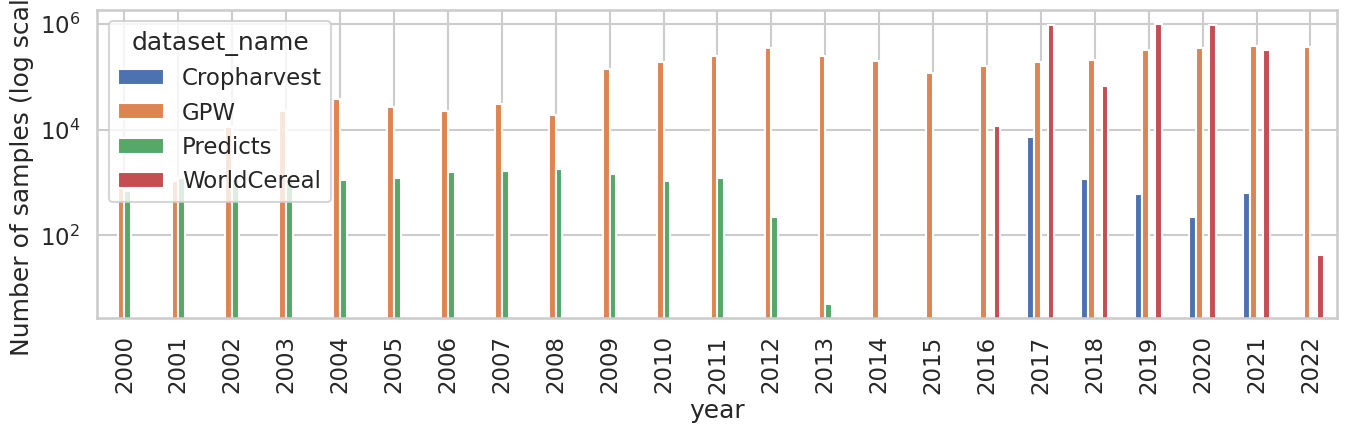

In [198]:
samples[['year', 'dataset_name']].value_counts().unstack(fill_value=0).plot(kind='bar', ylabel='Number of samples (log scale)', figsize=(16,4), logy=True)

In [199]:
data = samples 

### Spectral indices

In [200]:
import numexpr as ne

pref = 'glad.SeasConv.ard2_m_30m_s'
suff = 'go_epsg.4326_v20230908'
dates = ['0101_0228','0301_0430','0501_0630','0701_0831','0901_1031','1101_1231']
bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermal']

indices = {}

for dt in dates:
    local_dict = { b: data[f'{b}_{pref}_{dt}_{suff}'] for b in bands}
    indices[f'ndvi_{pref}_{dt}_{suff}'] = f'( ( (nir * 0.004) - (red * 0.004) ) / ( (nir * 0.004) + (red * 0.004) ) ) * 125 + 125', local_dict
    indices[f'ndwi_{pref}_{dt}_{suff}'] = f'( ( (nir * 0.004) - (swir1 * 0.004) ) / ( (nir * 0.004) + (swir1 * 0.004) ) ) * 125 + 125', local_dict
    indices[f'savi_{pref}_{dt}_{suff}'] = f'( ( (nir * 0.004) - (red * 0.004) )*1.5 / ( (nir * 0.004) + (red * 0.004)  + 0.5) ) * 125 + 125', local_dict
    indices[f'msavi_{pref}_{dt}_{suff}'] = f'( (2 *  (nir * 0.004) + 1 - sqrt((2 *  (nir * 0.004) + 1)**2 - 8 * ( (nir * 0.004) - (red * 0.004) ))) / 2 ) * 125 + 125', local_dict
    indices[f'nbr_{pref}_{dt}_{suff}'] = f'( ( (nir * 0.004) - ( swir2 * 0.004) ) / ( (nir * 0.004) + ( swir2 * 0.004) ) ) * 125 + 125', local_dict
    indices[f'ndmi_{pref}_{dt}_{suff}'] = f'( ( (nir * 0.004) -  (swir1 * 0.004)) / ( (nir * 0.004) +  (swir1 * 0.004)) ) * 125 + 125', local_dict
    indices[f'nbr2_{pref}_{dt}_{suff}'] = f'( ( (swir1 * 0.004) - ( thermal * 0.004) ) / ( (swir1 * 0.004) + ( thermal * 0.004) ) ) * 125 + 125', local_dict
    indices[f'rei_{pref}_{dt}_{suff}'] = f'( ( (nir * 0.004) - blue * 0.004)/( (nir * 0.004) + (blue * 0.004) *  (nir * 0.004)) ) * 125 + 125', local_dict
    indices[f'bsi_{pref}_{dt}_{suff}'] = f'( ( ( (swir1 * 0.004) + (red * 0.004) ) - ( (nir * 0.004) + blue * 0.004) ) / ( ( (swir1 * 0.004) + (red * 0.004) ) + ( (nir * 0.004) + (blue * 0.004)) ) ) * 125 + 125', local_dict
    indices[f'ndti_{pref}_{dt}_{suff}'] = f'( ( (swir1 * 0.004) - (swir2 * 0.004) )  / ( (swir1 * 0.004) + (swir2 * 0.004) )  ) * 125 + 125', local_dict
    indices[f'ndsi_{pref}_{dt}_{suff}'] = f'( ( (green * 0.004) -  (swir1 * 0.004) ) / ( (green * 0.004) +  (swir1 * 0.004) ) ) * 125 + 125', local_dict
    indices[f'ndsmi_{pref}_{dt}_{suff}'] = f'( ( (nir * 0.004) - (swir2 * 0.004) )  / ( (nir * 0.004) + (swir2 * 0.004) )  ) * 125 + 125', local_dict
    indices[f'nirv_{pref}_{dt}_{suff}'] = f'( ( ( ( (nir * 0.004) - (red * 0.004) ) / ( (nir * 0.004) + (red * 0.004) ) ) - 0.08) *  (nir * 0.004) ) * 125 + 125', local_dict
    indices[f'evi_{pref}_{dt}_{suff}'] = f'( 2.5 * ( (nir * 0.004) - (red * 0.004) ) / ( (nir * 0.004) + 6 * (red * 0.004) - 7.5 * (blue * 0.004) + 1) ) * 125 + 125', local_dict
    indices[f'fapar_{pref}_{dt}_{suff}'] = f'( ((( (( (nir * 0.004) - (red * 0.004) ) / ( (nir * 0.004) + (red * 0.004) )) - 0.03) * (0.95 - 0.001)) / (0.96 - 0.03)) + 0.001 ) * 125 + 125', local_dict

result = {}
for index, (expr, local_dict) in indices.items():
    print(f'Calculating {index}')
    result[index] = ne.evaluate(expr, local_dict=local_dict).round()
    
data = data.join(pd.DataFrame(result))
data

Calculating ndvi_glad.SeasConv.ard2_m_30m_s_0101_0228_go_epsg.4326_v20230908
Calculating ndwi_glad.SeasConv.ard2_m_30m_s_0101_0228_go_epsg.4326_v20230908
Calculating savi_glad.SeasConv.ard2_m_30m_s_0101_0228_go_epsg.4326_v20230908
Calculating msavi_glad.SeasConv.ard2_m_30m_s_0101_0228_go_epsg.4326_v20230908
Calculating nbr_glad.SeasConv.ard2_m_30m_s_0101_0228_go_epsg.4326_v20230908
Calculating ndmi_glad.SeasConv.ard2_m_30m_s_0101_0228_go_epsg.4326_v20230908
Calculating nbr2_glad.SeasConv.ard2_m_30m_s_0101_0228_go_epsg.4326_v20230908
Calculating rei_glad.SeasConv.ard2_m_30m_s_0101_0228_go_epsg.4326_v20230908
Calculating bsi_glad.SeasConv.ard2_m_30m_s_0101_0228_go_epsg.4326_v20230908
Calculating ndti_glad.SeasConv.ard2_m_30m_s_0101_0228_go_epsg.4326_v20230908
Calculating ndsi_glad.SeasConv.ard2_m_30m_s_0101_0228_go_epsg.4326_v20230908
Calculating ndsmi_glad.SeasConv.ard2_m_30m_s_0101_0228_go_epsg.4326_v20230908
Calculating nirv_glad.SeasConv.ard2_m_30m_s_0101_0228_go_epsg.4326_v20230908


,class,x,y,class_pct,vi_tile_id,dataset_name,imagery,glad_tile_id,ref_date,year,...,ndmi_glad.SeasConv.ard2_m_30m_s_1101_1231_go_epsg.4326_v20230908,nbr2_glad.SeasConv.ard2_m_30m_s_1101_1231_go_epsg.4326_v20230908,rei_glad.SeasConv.ard2_m_30m_s_1101_1231_go_epsg.4326_v20230908,bsi_glad.SeasConv.ard2_m_30m_s_1101_1231_go_epsg.4326_v20230908,ndti_glad.SeasConv.ard2_m_30m_s_1101_1231_go_epsg.4326_v20230908,ndsi_glad.SeasConv.ard2_m_30m_s_1101_1231_go_epsg.4326_v20230908,ndsmi_glad.SeasConv.ard2_m_30m_s_1101_1231_go_epsg.4326_v20230908,nirv_glad.SeasConv.ard2_m_30m_s_1101_1231_go_epsg.4326_v20230908,evi_glad.SeasConv.ard2_m_30m_s_1101_1231_go_epsg.4326_v20230908,fapar_glad.SeasConv.ard2_m_30m_s_1101_1231_go_epsg.4326_v20230908
0,3,0.452821,6.793882,39,8322,GPW,Bing,000E_06N,2014-01-03,2014,...,153.0,60.0,234.0,105.0,173.0,62.0,194.0,155.0,192.0,215.0
1,3,0.453321,6.793882,97,8322,GPW,Bing,000E_06N,2014-01-03,2014,...,161.0,52.0,233.0,97.0,174.0,68.0,201.0,154.0,192.0,216.0
2,3,0.453821,6.793882,100,8322,GPW,Bing,000E_06N,2014-01-03,2014,...,159.0,53.0,237.0,99.0,179.0,63.0,204.0,155.0,191.0,218.0
3,3,0.454321,6.793882,94,8322,GPW,Bing,000E_06N,2014-01-03,2014,...,158.0,55.0,234.0,100.0,176.0,67.0,201.0,154.0,192.0,215.0
4,3,0.454821,6.793882,28,8322,GPW,Bing,000E_06N,2014-01-03,2014,...,161.0,57.0,233.0,98.0,173.0,70.0,200.0,157.0,196.0,215.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038540,3,177.242778,-17.108333,100,-1,Predicts,NA,177E_17S,2007-01-01,2007,...,172.0,53.0,243.0,83.0,180.0,49.0,213.0,168.0,210.0,233.0
7038541,3,177.180278,-17.189167,100,-1,Predicts,NA,177E_17S,2007-01-01,2007,...,170.0,46.0,241.0,88.0,178.0,59.0,210.0,158.0,195.0,225.0
7038542,3,177.171944,-17.194722,100,-1,Predicts,NA,177E_17S,2007-01-01,2007,...,162.0,50.0,240.0,97.0,174.0,61.0,202.0,154.0,189.0,220.0
7038543,3,177.126944,-17.290556,100,-1,Predicts,NA,177E_17S,2007-01-01,2007,...,178.0,50.0,230.0,78.0,173.0,80.0,212.0,166.0,218.0,224.0


In [201]:
import numpy as np


local_dict = {}
for dt in dates:
    local_dict[f'ndvi_{dt}'] = data[f'ndvi_{pref}_{dt}_{suff}']

expr = f'( where( ndvi_0101_0228 <= 169, 100, 0) + where( ndvi_0301_0430 <= 169, 100, 0) + ' + \
       f'  where( ndvi_0501_0630 <= 169, 100, 0) + where( ndvi_0701_0831 <= 169, 100, 0) + ' + \
       f'  where( ndvi_0501_0630 <= 169, 100, 0) + where( ndvi_0701_0831 <= 169, 100, 0) ) / 6'                
data[f'bsf_{pref}_{suff}'] = ne.evaluate(expr, local_dict=local_dict).round()
data
#indices['bsf_{pref}_{dt}_{suff}'] = 

,class,x,y,class_pct,vi_tile_id,dataset_name,imagery,glad_tile_id,ref_date,year,...,nbr2_glad.SeasConv.ard2_m_30m_s_1101_1231_go_epsg.4326_v20230908,rei_glad.SeasConv.ard2_m_30m_s_1101_1231_go_epsg.4326_v20230908,bsi_glad.SeasConv.ard2_m_30m_s_1101_1231_go_epsg.4326_v20230908,ndti_glad.SeasConv.ard2_m_30m_s_1101_1231_go_epsg.4326_v20230908,ndsi_glad.SeasConv.ard2_m_30m_s_1101_1231_go_epsg.4326_v20230908,ndsmi_glad.SeasConv.ard2_m_30m_s_1101_1231_go_epsg.4326_v20230908,nirv_glad.SeasConv.ard2_m_30m_s_1101_1231_go_epsg.4326_v20230908,evi_glad.SeasConv.ard2_m_30m_s_1101_1231_go_epsg.4326_v20230908,fapar_glad.SeasConv.ard2_m_30m_s_1101_1231_go_epsg.4326_v20230908,bsf_glad.SeasConv.ard2_m_30m_s_go_epsg.4326_v20230908
0,3,0.452821,6.793882,39,8322,GPW,Bing,000E_06N,2014-01-03,2014,...,60.0,234.0,105.0,173.0,62.0,194.0,155.0,192.0,215.0,0.0
1,3,0.453321,6.793882,97,8322,GPW,Bing,000E_06N,2014-01-03,2014,...,52.0,233.0,97.0,174.0,68.0,201.0,154.0,192.0,216.0,0.0
2,3,0.453821,6.793882,100,8322,GPW,Bing,000E_06N,2014-01-03,2014,...,53.0,237.0,99.0,179.0,63.0,204.0,155.0,191.0,218.0,0.0
3,3,0.454321,6.793882,94,8322,GPW,Bing,000E_06N,2014-01-03,2014,...,55.0,234.0,100.0,176.0,67.0,201.0,154.0,192.0,215.0,0.0
4,3,0.454821,6.793882,28,8322,GPW,Bing,000E_06N,2014-01-03,2014,...,57.0,233.0,98.0,173.0,70.0,200.0,157.0,196.0,215.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038540,3,177.242778,-17.108333,100,-1,Predicts,NA,177E_17S,2007-01-01,2007,...,53.0,243.0,83.0,180.0,49.0,213.0,168.0,210.0,233.0,0.0
7038541,3,177.180278,-17.189167,100,-1,Predicts,NA,177E_17S,2007-01-01,2007,...,46.0,241.0,88.0,178.0,59.0,210.0,158.0,195.0,225.0,0.0
7038542,3,177.171944,-17.194722,100,-1,Predicts,NA,177E_17S,2007-01-01,2007,...,50.0,240.0,97.0,174.0,61.0,202.0,154.0,189.0,220.0,0.0
7038543,3,177.126944,-17.290556,100,-1,Predicts,NA,177E_17S,2007-01-01,2007,...,50.0,230.0,78.0,173.0,80.0,212.0,166.0,218.0,224.0,0.0


In [202]:
from datetime import datetime
import math

def geo_temp(fi, day, a=37.03043, b=-15.43029):
    f =fi
    pi = math.pi 

    #math.cos((day - 18) * math.pi / 182.5 + math.pow(2, (1 - math.copysign(1, fi))) * math.pi) 
    sign = 'where(abs(fi) - fi == 0, 1, -1)'
    costeta = f"cos((day - 18) * pi / 182.5 + 2**(1 - {sign}) * pi)"

    #math.cos(fi * math.pi / 180)
    cosfi = "cos(fi * pi / 180)"
    A = cosfi

    #(1 - costeta) * abs(math.sin(fi * math.pi / 180) )
    B = f"(1 - {costeta}) * abs(sin(fi * pi / 180) )"

    x = f"(a * {A} + b * {B})"
    return ne.evaluate(x)

def add_geo_temp(pts):

    elev_corr = 0.006 * pts['dtm.bareearth_ensemble_p10_30m_s_2018_go_epsg4326_v20230210'].to_numpy()

    for m in range(1,13):
        doy = (datetime.strptime(f'2000-{m}-15', '%Y-%m-%d').timetuple().tm_yday)
        max_temp_name = f'clm_lst_max.geom.temp_m_30m_s_m{m}' 
        min_temp_name = f'clm_lst_min.geom.temp_m_30m_s_m{m}'
        print(f"Adding {max_temp_name} & {min_temp_name}")
        pts[max_temp_name] = ((geo_temp(pts['y'].to_numpy(), day=doy, a=37.03043, b=-15.43029) - elev_corr) * 100).round()
        pts[min_temp_name] = ((geo_temp(pts['y'].to_numpy(), day=doy, a=24.16453, b=-15.71751) - elev_corr) * 100).round()

    return(pts)

add_geo_temp(data)
data

Adding clm_lst_max.geom.temp_m_30m_s_m1 & clm_lst_min.geom.temp_m_30m_s_m1
Adding clm_lst_max.geom.temp_m_30m_s_m2 & clm_lst_min.geom.temp_m_30m_s_m2
Adding clm_lst_max.geom.temp_m_30m_s_m3 & clm_lst_min.geom.temp_m_30m_s_m3
Adding clm_lst_max.geom.temp_m_30m_s_m4 & clm_lst_min.geom.temp_m_30m_s_m4
Adding clm_lst_max.geom.temp_m_30m_s_m5 & clm_lst_min.geom.temp_m_30m_s_m5
Adding clm_lst_max.geom.temp_m_30m_s_m6 & clm_lst_min.geom.temp_m_30m_s_m6
Adding clm_lst_max.geom.temp_m_30m_s_m7 & clm_lst_min.geom.temp_m_30m_s_m7
Adding clm_lst_max.geom.temp_m_30m_s_m8 & clm_lst_min.geom.temp_m_30m_s_m8
Adding clm_lst_max.geom.temp_m_30m_s_m9 & clm_lst_min.geom.temp_m_30m_s_m9
Adding clm_lst_max.geom.temp_m_30m_s_m10 & clm_lst_min.geom.temp_m_30m_s_m10
Adding clm_lst_max.geom.temp_m_30m_s_m11 & clm_lst_min.geom.temp_m_30m_s_m11
Adding clm_lst_max.geom.temp_m_30m_s_m12 & clm_lst_min.geom.temp_m_30m_s_m12


,class,x,y,class_pct,vi_tile_id,dataset_name,imagery,glad_tile_id,ref_date,year,...,clm_lst_max.geom.temp_m_30m_s_m8,clm_lst_min.geom.temp_m_30m_s_m8,clm_lst_max.geom.temp_m_30m_s_m9,clm_lst_min.geom.temp_m_30m_s_m9,clm_lst_max.geom.temp_m_30m_s_m10,clm_lst_min.geom.temp_m_30m_s_m10,clm_lst_max.geom.temp_m_30m_s_m11,clm_lst_min.geom.temp_m_30m_s_m11,clm_lst_max.geom.temp_m_30m_s_m12,clm_lst_min.geom.temp_m_30m_s_m12
0,3,0.452821,6.793882,39,8322,GPW,Bing,000E_06N,2014-01-03,2014,...,2070.0,792.0,2005.0,726.0,1916.0,635.0,1822.0,540.0,1754.0,470.0
1,3,0.453321,6.793882,97,8322,GPW,Bing,000E_06N,2014-01-03,2014,...,2084.0,806.0,2019.0,740.0,1930.0,649.0,1836.0,553.0,1767.0,484.0
2,3,0.453821,6.793882,100,8322,GPW,Bing,000E_06N,2014-01-03,2014,...,2092.0,814.0,2027.0,748.0,1938.0,658.0,1844.0,562.0,1776.0,492.0
3,3,0.454321,6.793882,94,8322,GPW,Bing,000E_06N,2014-01-03,2014,...,2109.0,831.0,2044.0,765.0,1955.0,674.0,1861.0,579.0,1793.0,509.0
4,3,0.454821,6.793882,28,8322,GPW,Bing,000E_06N,2014-01-03,2014,...,2114.0,836.0,2049.0,770.0,1961.0,680.0,1867.0,584.0,1798.0,514.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038540,3,177.242778,-17.108333,100,-1,Predicts,NA,177E_17S,2007-01-01,2007,...,1100.0,-145.0,1262.0,19.0,1483.0,244.0,1716.0,482.0,1887.0,656.0
7038541,3,177.180278,-17.189167,100,-1,Predicts,NA,177E_17S,2007-01-01,2007,...,2267.0,1022.0,2429.0,1187.0,2651.0,1413.0,2886.0,1653.0,3057.0,1827.0
7038542,3,177.171944,-17.194722,100,-1,Predicts,NA,177E_17S,2007-01-01,2007,...,2450.0,1205.0,2613.0,1371.0,2835.0,1597.0,3070.0,1836.0,3241.0,2010.0
7038543,3,177.126944,-17.290556,100,-1,Predicts,NA,177E_17S,2007-01-01,2007,...,1019.0,-226.0,1182.0,-60.0,1405.0,168.0,1641.0,408.0,1814.0,584.0


In [203]:
indices = ['ndvi','ndwi','savi','msavi','nbr','ndmi','nbr2','rei','bsi','ndti','ndsi','ndsmi','nirv','evi','fapar']
col_indices = []
for ind in indices:
    col_indices += list(data.columns[data.columns.str.contains(ind)])

min_val, max_val = 0, 250
for c in col_indices:
    print(f"Clipping {c}")
    min_mask = np.logical_or(data[c] < min_val, data[c] == -np.inf)
    max_mask = np.logical_or(data[c] > max_val, data[c] == np.inf)
    data.loc[min_mask, c] = min_val
    data.loc[max_mask, c] = max_val

Clipping ndvi_glad.SeasConv.ard2_m_30m_s_0101_0228_go_epsg.4326_v20230908
Clipping ndvi_glad.SeasConv.ard2_m_30m_s_0301_0430_go_epsg.4326_v20230908
Clipping ndvi_glad.SeasConv.ard2_m_30m_s_0501_0630_go_epsg.4326_v20230908
Clipping ndvi_glad.SeasConv.ard2_m_30m_s_0701_0831_go_epsg.4326_v20230908
Clipping ndvi_glad.SeasConv.ard2_m_30m_s_0901_1031_go_epsg.4326_v20230908
Clipping ndvi_glad.SeasConv.ard2_m_30m_s_1101_1231_go_epsg.4326_v20230908
Clipping ndwi_glad.SeasConv.ard2_m_30m_s_0101_0228_go_epsg.4326_v20230908
Clipping ndwi_glad.SeasConv.ard2_m_30m_s_0301_0430_go_epsg.4326_v20230908
Clipping ndwi_glad.SeasConv.ard2_m_30m_s_0501_0630_go_epsg.4326_v20230908
Clipping ndwi_glad.SeasConv.ard2_m_30m_s_0701_0831_go_epsg.4326_v20230908
Clipping ndwi_glad.SeasConv.ard2_m_30m_s_0901_1031_go_epsg.4326_v20230908
Clipping ndwi_glad.SeasConv.ard2_m_30m_s_1101_1231_go_epsg.4326_v20230908
Clipping savi_glad.SeasConv.ard2_m_30m_s_0101_0228_go_epsg.4326_v20230908
Clipping msavi_glad.SeasConv.ard2_m_30

In [204]:
accessibility = ['lcv_accessibility.to.cities_map.ox']
col_accessibility = []
for acces in accessibility:
    col_accessibility += list(data.columns[data.columns.str.contains(acces)])

for c in col_accessibility:
    print(f"Fixing nan fro {c}")
    #print(f'{c} => {data[data[c] == 65535].shape}')
    data.loc[data[c] == 65535, c] = np.nan
    #min_mask = np.logical_or(data[c] < min_val, data[c] == -np.inf)
    #max_mask = np.logical_or(data[c] > max_val, data[c] == np.inf)
    #data.loc[min_mask, c] = min_val
    #data.loc[max_mask, c] = max_val

Fixing nan fro lcv_accessibility.to.cities_map.ox.var3_m_1km_s0..0cm_2015_v14052019
Fixing nan fro lcv_accessibility.to.cities_map.ox.var8_m_1km_s0..0cm_2015_v14052019
Fixing nan fro lcv_accessibility.to.cities_map.ox.var10_m_1km_s0..0cm_2015_v14052019
Fixing nan fro lcv_accessibility.to.cities_map.ox.var11_m_1km_s0..0cm_2015_v14052019
Fixing nan fro lcv_accessibility.to.cities_map.ox.var1_m_1km_s0..0cm_2015_v14052019
Fixing nan fro lcv_accessibility.to.cities_map.ox.var5_m_1km_s0..0cm_2015_v14052019
Fixing nan fro lcv_accessibility.to.cities_map.ox.var2_m_1km_s0..0cm_2015_v14052019
Fixing nan fro lcv_accessibility.to.cities_map.ox.var4_m_1km_s0..0cm_2015_v14052019
Fixing nan fro lcv_accessibility.to.cities_map.ox.var7_m_1km_s0..0cm_2015_v14052019
Fixing nan fro lcv_accessibility.to.cities_map.ox.var12_m_1km_s0..0cm_2015_v14052019
Fixing nan fro lcv_accessibility.to.cities_map.ox.var9_m_1km_s0..0cm_2015_v14052019
Fixing nan fro lcv_accessibility.to.cities_map.ox.var6_m_1km_s0..0cm_2015

In [205]:
cov_idx = list(data.columns).index('cv_group') + 1
covs = data.columns[cov_idx:]
target_column = 'class'
spatial_cv_column = 'cv_group'
weight_column = 'class_pct'
cv_njobs = 5
cv_folds = 5
seed = 1989

In [206]:
import bottleneck as bn
c_min, c_max, c_mean, c_std = [], [], [], []
for c in covs:
    c_min.append(bn.nanmin(data[c]))
    c_max.append(bn.nanmax(data[c]))
    c_mean.append(bn.nanmean(data[c]))
    c_std.append(bn.nanmean(data[c]))

pd.DataFrame({'feature':covs, 'min': c_min, 'max': c_max, 'mean': c_mean, 'std': c_std}).sort_values('feature').to_csv('features_stats.csv')

In [207]:
import numpy as np
from eumap.misc import ttprint

any_nan_samples = np.sum(np.isnan(data[covs].to_numpy()).astype('int'), axis=0)
cols_to_remove = []

for th in [1, 0.5, 0.2, 0.1, 0.05, 0.02]:
    ttprint(f"Columns with {th*100}% of nan values")
    for c,s in zip(covs, any_nan_samples):
        if s > (data.shape[0] * th):
            ttprint(f' - {s} => {c}')
            cols_to_remove += [c]

cols_to_remove = set(cols_to_remove)
ttprint(cols_to_remove)
ttprint(f"Removing {len(cols_to_remove)} columns (>= {th*100}% of nan values)")

[21:01:29] Columns with 100% of nan values
[21:01:29] Columns with 50.0% of nan values
[21:01:29] Columns with 20.0% of nan values
[21:01:29] Columns with 10.0% of nan values
[21:01:29] Columns with 5.0% of nan values
[21:01:29] Columns with 2.0% of nan values
[21:01:29]  - 145813 => lcv_accessibility.to.cities_map.ox.var10_m_1km_s0..0cm_2015_v14052019
[21:01:29]  - 173635 => lcv_accessibility.to.cities_map.ox.var12_m_1km_s0..0cm_2015_v14052019
[21:01:29] {'lcv_accessibility.to.cities_map.ox.var12_m_1km_s0..0cm_2015_v14052019', 'lcv_accessibility.to.cities_map.ox.var10_m_1km_s0..0cm_2015_v14052019'}
[21:01:29] Removing 2 columns (>= 2.0% of nan values)


In [208]:
data = data.drop(columns=cols_to_remove)
cov_idx = list(data.columns).index('cv_group') + 1
covs = data.columns[cov_idx:]

In [209]:
nan_samples = data[np.any(np.isnan(data[covs].to_numpy()).astype('int'), axis=1)].index
ttprint(f"Removing {len(nan_samples)} samples with at least one column with nan")
data = data.drop(nan_samples)
data

[21:02:15] Removing 108688 samples with at least one column with nan


,class,x,y,class_pct,vi_tile_id,dataset_name,imagery,glad_tile_id,ref_date,year,...,clm_lst_max.geom.temp_m_30m_s_m8,clm_lst_min.geom.temp_m_30m_s_m8,clm_lst_max.geom.temp_m_30m_s_m9,clm_lst_min.geom.temp_m_30m_s_m9,clm_lst_max.geom.temp_m_30m_s_m10,clm_lst_min.geom.temp_m_30m_s_m10,clm_lst_max.geom.temp_m_30m_s_m11,clm_lst_min.geom.temp_m_30m_s_m11,clm_lst_max.geom.temp_m_30m_s_m12,clm_lst_min.geom.temp_m_30m_s_m12
0,3,0.452821,6.793882,39,8322,GPW,Bing,000E_06N,2014-01-03,2014,...,2070.0,792.0,2005.0,726.0,1916.0,635.0,1822.0,540.0,1754.0,470.0
1,3,0.453321,6.793882,97,8322,GPW,Bing,000E_06N,2014-01-03,2014,...,2084.0,806.0,2019.0,740.0,1930.0,649.0,1836.0,553.0,1767.0,484.0
2,3,0.453821,6.793882,100,8322,GPW,Bing,000E_06N,2014-01-03,2014,...,2092.0,814.0,2027.0,748.0,1938.0,658.0,1844.0,562.0,1776.0,492.0
3,3,0.454321,6.793882,94,8322,GPW,Bing,000E_06N,2014-01-03,2014,...,2109.0,831.0,2044.0,765.0,1955.0,674.0,1861.0,579.0,1793.0,509.0
4,3,0.454821,6.793882,28,8322,GPW,Bing,000E_06N,2014-01-03,2014,...,2114.0,836.0,2049.0,770.0,1961.0,680.0,1867.0,584.0,1798.0,514.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038533,3,177.510833,-16.790833,100,-1,Predicts,NA,177E_16S,2007-01-01,2007,...,2484.0,1237.0,2643.0,1398.0,2860.0,1619.0,3089.0,1853.0,3257.0,2024.0
7038536,3,177.139167,-17.339167,100,-1,Predicts,NA,177E_17S,2007-01-01,2007,...,1402.0,158.0,1566.0,324.0,1790.0,552.0,2026.0,794.0,2199.0,969.0
7038539,3,177.328056,-17.006944,100,-1,Predicts,NA,177E_17S,2007-01-01,2007,...,2595.0,1348.0,2755.0,1512.0,2975.0,1736.0,3207.0,1972.0,3377.0,2145.0
7038540,3,177.242778,-17.108333,100,-1,Predicts,NA,177E_17S,2007-01-01,2007,...,1100.0,-145.0,1262.0,19.0,1483.0,244.0,1716.0,482.0,1887.0,656.0


In [210]:
max_weig = np.max(data[weight_column])
data[weight_column] = data[weight_column] / max_weig
data = data[data[weight_column] > 0.75]
data

,class,x,y,class_pct,vi_tile_id,dataset_name,imagery,glad_tile_id,ref_date,year,...,clm_lst_max.geom.temp_m_30m_s_m8,clm_lst_min.geom.temp_m_30m_s_m8,clm_lst_max.geom.temp_m_30m_s_m9,clm_lst_min.geom.temp_m_30m_s_m9,clm_lst_max.geom.temp_m_30m_s_m10,clm_lst_min.geom.temp_m_30m_s_m10,clm_lst_max.geom.temp_m_30m_s_m11,clm_lst_min.geom.temp_m_30m_s_m11,clm_lst_max.geom.temp_m_30m_s_m12,clm_lst_min.geom.temp_m_30m_s_m12
1,3,0.453321,6.793882,0.97,8322,GPW,Bing,000E_06N,2014-01-03,2014,...,2084.0,806.0,2019.0,740.0,1930.0,649.0,1836.0,553.0,1767.0,484.0
2,3,0.453821,6.793882,1.00,8322,GPW,Bing,000E_06N,2014-01-03,2014,...,2092.0,814.0,2027.0,748.0,1938.0,658.0,1844.0,562.0,1776.0,492.0
3,3,0.454321,6.793882,0.94,8322,GPW,Bing,000E_06N,2014-01-03,2014,...,2109.0,831.0,2044.0,765.0,1955.0,674.0,1861.0,579.0,1793.0,509.0
6,3,0.455821,6.793882,1.00,8322,GPW,Bing,000E_06N,2014-01-03,2014,...,2113.0,835.0,2048.0,769.0,1959.0,679.0,1865.0,583.0,1797.0,513.0
7,3,0.456321,6.793882,1.00,8322,GPW,Bing,000E_06N,2014-01-03,2014,...,2108.0,830.0,2043.0,764.0,1954.0,673.0,1860.0,577.0,1791.0,508.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038533,3,177.510833,-16.790833,1.00,-1,Predicts,NA,177E_16S,2007-01-01,2007,...,2484.0,1237.0,2643.0,1398.0,2860.0,1619.0,3089.0,1853.0,3257.0,2024.0
7038536,3,177.139167,-17.339167,1.00,-1,Predicts,NA,177E_17S,2007-01-01,2007,...,1402.0,158.0,1566.0,324.0,1790.0,552.0,2026.0,794.0,2199.0,969.0
7038539,3,177.328056,-17.006944,1.00,-1,Predicts,NA,177E_17S,2007-01-01,2007,...,2595.0,1348.0,2755.0,1512.0,2975.0,1736.0,3207.0,1972.0,3377.0,2145.0
7038540,3,177.242778,-17.108333,1.00,-1,Predicts,NA,177E_17S,2007-01-01,2007,...,1100.0,-145.0,1262.0,19.0,1483.0,244.0,1716.0,482.0,1887.0,656.0


In [212]:
data_calib = []
for tile, rows in data.groupby(spatial_cv_column):
    n_samples = int(rows.shape[0] * 0.05)
    data_calib.append(rows.sample(n_samples, random_state=seed))
data_calib = pd.concat(data_calib)
data_calib

,class,x,y,class_pct,vi_tile_id,dataset_name,imagery,glad_tile_id,ref_date,year,...,clm_lst_max.geom.temp_m_30m_s_m8,clm_lst_min.geom.temp_m_30m_s_m8,clm_lst_max.geom.temp_m_30m_s_m9,clm_lst_min.geom.temp_m_30m_s_m9,clm_lst_max.geom.temp_m_30m_s_m10,clm_lst_min.geom.temp_m_30m_s_m10,clm_lst_max.geom.temp_m_30m_s_m11,clm_lst_min.geom.temp_m_30m_s_m11,clm_lst_max.geom.temp_m_30m_s_m12,clm_lst_min.geom.temp_m_30m_s_m12
6630150,3,9.567917,35.852060,1.00,-1,Cropharvest,NA,009E_35N,2021-01-01,2021,...,34.0,-1011.0,-287.0,-1338.0,-728.0,-1786.0,-1193.0,-2260.0,-1532.0,-2606.0
6630161,3,9.986517,36.568043,1.00,-1,Cropharvest,NA,009E_36N,2021-01-01,2021,...,2238.0,1202.0,1911.0,869.0,1463.0,413.0,990.0,-69.0,644.0,-420.0
6630178,3,9.642128,36.359260,1.00,-1,Cropharvest,NA,009E_36N,2021-01-01,2021,...,1514.0,476.0,1188.0,144.0,743.0,-310.0,272.0,-789.0,-72.0,-1139.0
6654943,3,10.038089,36.641567,1.00,-1,Cropharvest,NA,010E_36N,2021-01-01,2021,...,2581.0,1547.0,2253.0,1213.0,1805.0,756.0,1331.0,273.0,985.0,-79.0
6901815,3,-55.517042,49.070897,1.00,-1,Cropharvest,NA,055W_49N,2017-01-01,2017,...,1954.0,1109.0,1539.0,686.0,972.0,108.0,372.0,-503.0,-66.0,-949.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3302332,3,126.165490,8.941886,1.00,9425,GPW,Google,126E_08N,2021-07-23,2021,...,3208.0,1937.0,3123.0,1850.0,3006.0,1731.0,2883.0,1605.0,2792.0,1513.0
3302327,3,126.162994,8.941886,1.00,9425,GPW,Google,126E_08N,2021-07-23,2021,...,3277.0,2006.0,3192.0,1919.0,3075.0,1800.0,2952.0,1674.0,2861.0,1582.0
3302204,1,126.157990,8.944886,0.89,9425,GPW,Google,126E_08N,2021-07-23,2021,...,3588.0,2317.0,3503.0,2230.0,3386.0,2111.0,3263.0,1985.0,3173.0,1893.0
3302358,3,126.160490,8.940886,1.00,9425,GPW,Google,126E_08N,2021-07-23,2021,...,3281.0,2009.0,3195.0,1922.0,3079.0,1803.0,2955.0,1678.0,2865.0,1586.0


In [213]:
data_train = data.drop(index=data_calib.index)
data_train

,class,x,y,class_pct,vi_tile_id,dataset_name,imagery,glad_tile_id,ref_date,year,...,clm_lst_max.geom.temp_m_30m_s_m8,clm_lst_min.geom.temp_m_30m_s_m8,clm_lst_max.geom.temp_m_30m_s_m9,clm_lst_min.geom.temp_m_30m_s_m9,clm_lst_max.geom.temp_m_30m_s_m10,clm_lst_min.geom.temp_m_30m_s_m10,clm_lst_max.geom.temp_m_30m_s_m11,clm_lst_min.geom.temp_m_30m_s_m11,clm_lst_max.geom.temp_m_30m_s_m12,clm_lst_min.geom.temp_m_30m_s_m12
1,3,0.453321,6.793882,0.97,8322,GPW,Bing,000E_06N,2014-01-03,2014,...,2084.0,806.0,2019.0,740.0,1930.0,649.0,1836.0,553.0,1767.0,484.0
2,3,0.453821,6.793882,1.00,8322,GPW,Bing,000E_06N,2014-01-03,2014,...,2092.0,814.0,2027.0,748.0,1938.0,658.0,1844.0,562.0,1776.0,492.0
3,3,0.454321,6.793882,0.94,8322,GPW,Bing,000E_06N,2014-01-03,2014,...,2109.0,831.0,2044.0,765.0,1955.0,674.0,1861.0,579.0,1793.0,509.0
6,3,0.455821,6.793882,1.00,8322,GPW,Bing,000E_06N,2014-01-03,2014,...,2113.0,835.0,2048.0,769.0,1959.0,679.0,1865.0,583.0,1797.0,513.0
7,3,0.456321,6.793882,1.00,8322,GPW,Bing,000E_06N,2014-01-03,2014,...,2108.0,830.0,2043.0,764.0,1954.0,673.0,1860.0,577.0,1791.0,508.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038533,3,177.510833,-16.790833,1.00,-1,Predicts,NA,177E_16S,2007-01-01,2007,...,2484.0,1237.0,2643.0,1398.0,2860.0,1619.0,3089.0,1853.0,3257.0,2024.0
7038536,3,177.139167,-17.339167,1.00,-1,Predicts,NA,177E_17S,2007-01-01,2007,...,1402.0,158.0,1566.0,324.0,1790.0,552.0,2026.0,794.0,2199.0,969.0
7038539,3,177.328056,-17.006944,1.00,-1,Predicts,NA,177E_17S,2007-01-01,2007,...,2595.0,1348.0,2755.0,1512.0,2975.0,1736.0,3207.0,1972.0,3377.0,2145.0
7038540,3,177.242778,-17.108333,1.00,-1,Predicts,NA,177E_17S,2007-01-01,2007,...,1100.0,-145.0,1262.0,19.0,1483.0,244.0,1716.0,482.0,1887.0,656.0


In [214]:
data_calib['vi_tile_id'] = data_calib['vi_tile_id'].astype('str')
data_train['vi_tile_id'] = data_train['vi_tile_id'].astype('str')

In [215]:
data_calib.to_parquet('global_samples_calibration_v20240210.pq')
data_train.to_parquet('global_samples_train_v20240210.pq')

## Modeling

In [1]:
import pandas as pd
data_calib = pd.read_parquet('global_samples_calibration_v1.pq')
data_train = pd.read_parquet('global_samples_train_v1.pq')

In [2]:
cov_idx = list(data_train.columns).index('ref_date') + 1
covs = data_train.columns[cov_idx:]
target_column = 'class'
spatial_cv_column = 'vi_tile_id'
weight_column = 'class_pct'
cv_njobs = 5
cv_folds = 5
seed = 1989

In [3]:
cov_wei_df = pd.read_csv('cov_weigts.csv').set_index('cov')
feature_weights = list(cov_wei_df.loc[covs,'weig_norm'])

In [4]:
data_calib = data_calib[data_calib[weight_column]==1]
data_train = data_train[data_train[weight_column]==1]
data = pd.concat([data_train, data_calib])

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data_train.loc[:,spatial_cv_column] = le.fit_transform(data_train[spatial_cv_column])
data_calib.loc[:,spatial_cv_column] = le.fit_transform(data_calib[spatial_cv_column])

In [6]:
import numpy as np
covs = covs[np.logical_or.reduce([covs.str.contains('accessibility'),
covs.str.contains('blue'),
covs.str.contains('bsf'),
covs.str.contains('bsi'),
covs.str.contains('clm'),
covs.str.contains('dtm.bareearth'),
covs.str.contains('evi'),
covs.str.contains('fapar'),
covs.str.contains('green'),
covs.str.contains('ndti'),
covs.str.contains('ndvi'),
covs.str.contains('ndwi'),
covs.str.contains('nir'),
covs.str.contains('nirv'),
covs.str.contains('red'),
covs.str.contains('road.distance_osm.highways.high.density'),
covs.str.contains('road.distance_osm.highways.low.density'),
covs.str.contains('swir1'),
covs.str.contains('swir2'),
covs.str.contains('thermal'),
covs.str.contains('water.distance_glad.interanual.dynamic.classes'),
covs.str.contains('wv_mcd19a2v061')])]

In [59]:
list(covs)

['green_glad.SeasConv.ard2_m_30m_s_0501_0630_go_epsg.4326_v20230908',
 'blue_glad.SeasConv.ard2_m_30m_s_1101_1231_go_epsg.4326_v20230908',
 'blue_glad.SeasConv.ard2_m_30m_s_0301_0430_go_epsg.4326_v20230908',
 'red_glad.SeasConv.ard2_m_30m_s_0501_0630_go_epsg.4326_v20230908',
 'green_glad.SeasConv.ard2_m_30m_s_0301_0430_go_epsg.4326_v20230908',
 'red_glad.SeasConv.ard2_m_30m_s_0101_0228_go_epsg.4326_v20230908',
 'nir_glad.SeasConv.ard2_m_30m_s_0301_0430_go_epsg.4326_v20230908',
 'green_glad.SeasConv.ard2_m_30m_s_0901_1031_go_epsg.4326_v20230908',
 'nir_glad.SeasConv.ard2_m_30m_s_0101_0228_go_epsg.4326_v20230908',
 'nir_glad.SeasConv.ard2_m_30m_s_0501_0630_go_epsg.4326_v20230908',
 'red_glad.SeasConv.ard2_m_30m_s_0301_0430_go_epsg.4326_v20230908',
 'blue_glad.SeasConv.ard2_m_30m_s_0701_0831_go_epsg.4326_v20230908',
 'blue_glad.SeasConv.ard2_m_30m_s_0101_0228_go_epsg.4326_v20230908',
 'red_glad.SeasConv.ard2_m_30m_s_1101_1231_go_epsg.4326_v20230908',
 'green_glad.SeasConv.ard2_m_30m_s_010

In [7]:
from skmap.mapper import build_ann
from skmap.mapper import LandMapper
from eumap.misc import ttprint
from pathlib import Path
from scipy.signal import argrelmin
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.experimental import enable_halving_search_cv 
from sklearn.feature_selection import RFECV, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GroupKFold, KFold
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from scipy.stats import uniform, randint
import joblib
import multiprocessing
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import sys
import xgboost as xgb

from pathlib import Path
from eumap.misc import ttprint
import joblib

def run_feature_selection(data, covs, target_column, weight_column, seed, spatial_cv_column = None,
                          subsample_pct = 0.1, n_rep = 5, n_cv = 5, ntrees = 50, local_min_pos = 0, order=2):

    #def log_loss_scorer(clf, X, y_true):
    #    class_labels = clf.classes_
    #    y_pred_proba = clf.predict_proba(X)
    #    error = log_loss(y_true, y_pred_proba, labels=class_labels)
    #    return error
    
    data_sub = data#.sample(int(data.shape[0] * subsample_pct), random_state=seed)
    rfecv_step = int(len(covs) * 0.05)
    rfe_step = int(rfecv_step / 2)
    
    cv, groups = KFold(n_cv), None
    if spatial_cv_column is not None:
        cv, groups = GroupKFold(n_cv), data[spatial_cv_column]
    
    ncpu = multiprocessing.cpu_count()
    if ntrees < ncpu:
        ncpu = ntrees

    ttprint(f"Finding n_features_to_select using RFECV (repetitions={n_rep} step={rfecv_step}, n_samples={data.shape[0]})")
    
    grid_scores = []
    for i in range(0,n_rep):
        rfecv = RFECV(estimator=RandomForestClassifier(ntrees, n_jobs=ncpu, random_state=i), cv=cv, step=rfecv_step, 
                      min_features_to_select=10, n_jobs=n_cv, scoring='neg_log_loss')
        rfecv.fit(data[covs], data[target_column], groups=groups)
        grid_scores += [rfecv.cv_results_['mean_test_score']]

    rfecv_mean_score = np.mean(np.stack(grid_scores, axis=0), axis=0)
    grid_scores_std = np.std(np.stack(grid_scores, axis=0), axis=0)
    
    rfecv_n_features_arr = list(range(rfecv.min_features_to_select, len(covs)+rfecv.step, rfecv.step))
    
    local_min_arr = argrelmin(rfecv_mean_score, order=order)[0]
    local_min = local_min_arr[0]
    if len(local_min_arr) > 1:
        local_min = local_min_arr[local_min_pos]
    
    n_features_to_select = rfecv_n_features_arr[local_min]
    
    ttprint(f"Finding best features using RFE (n_features_to_select = {n_features_to_select})")
    
    rfe = RFE(estimator=RandomForestClassifier(ntrees, n_jobs=ncpu, random_state=n_rep), step=rfe_step, n_features_to_select=n_features_to_select, verbose=1)
    rfe.fit(data[covs], data[target_column], **{'sample_weight': data[weight_column]})

    result = covs[rfe.support_]
    
    return result, rfecv_n_features_arr, rfecv_mean_score, grid_scores_std

fn_rfcv = 'global_samples_calibration_v1.1_rfecv.lz4' 
if Path(fn_rfcv).exists():
    ttprint(f'Reusing best features from {fn_rfcv}')
    locals().update(joblib.load(fn_rfcv))
    ttprint(f"Number of features selected: {len(covs_rfe)}")
else:
    covs_rfe, rfecv_n_features_arr, rfecv_mean_score, rfecv_std_score = run_feature_selection(data_calib, covs, target_column, 
                                                                                              weight_column, seed, spatial_cv_column, local_min_pos=0)
    joblib.dump({
        'covs_rfe':covs_rfe, 
        'rfecv_n_features_arr': rfecv_n_features_arr, 
        'rfecv_mean_score': rfecv_mean_score,
        'rfecv_std_score': rfecv_std_score
    }, fn_rfcv, compress='lz4')


[16:32:34] Reusing best features from global_samples_calibration_v1.1_rfecv.lz4
[16:32:34] Number of features selected: 130


In [236]:
import joblib
fn_rfcv = 'model_v20240210/rfecv_sub.lz4'
locals().update(joblib.load(fn_rfcv))

In [258]:
list(covs_rfe)

['red_glad.SeasConv.ard2_m_30m_s_1101_1231_go_epsg.4326_v20230908',
 'red_glad.SeasConv.ard2_m_30m_s_0701_0831_go_epsg.4326_v20230908',
 'nir_glad.SeasConv.ard2_m_30m_s_0301_0430_go_epsg.4326_v20230908',
 'swir1_glad.SeasConv.ard2_m_30m_s_0501_0630_go_epsg.4326_v20230908',
 'green_glad.SeasConv.ard2_m_30m_s_0701_0831_go_epsg.4326_v20230908',
 'nir_glad.SeasConv.ard2_m_30m_s_0501_0630_go_epsg.4326_v20230908',
 'swir1_glad.SeasConv.ard2_m_30m_s_0301_0430_go_epsg.4326_v20230908',
 'swir1_glad.SeasConv.ard2_m_30m_s_0701_0831_go_epsg.4326_v20230908',
 'swir2_glad.SeasConv.ard2_m_30m_s_0501_0630_go_epsg.4326_v20230908',
 'swir1_glad.SeasConv.ard2_m_30m_s_0901_1031_go_epsg.4326_v20230908',
 'clm_lst_mod11a2.daytime.m11_p50_1km_s0..0cm_2000..2021_v1.2',
 'clm_lst_mod11a2.daytime.m03_sd_1km_s0..0cm_2000..2021_v1.2',
 'clm_lst_mod11a2.nighttime.m07_p50_1km_s0..0cm_2000..2021_v1.2',
 'clm_lst_mod11a2.nighttime.m09_p50_1km_s0..0cm_2000..2021_v1.2',
 'clm_lst_mod11a2.daytime.m08_sd_1km_s0..0cm_2000

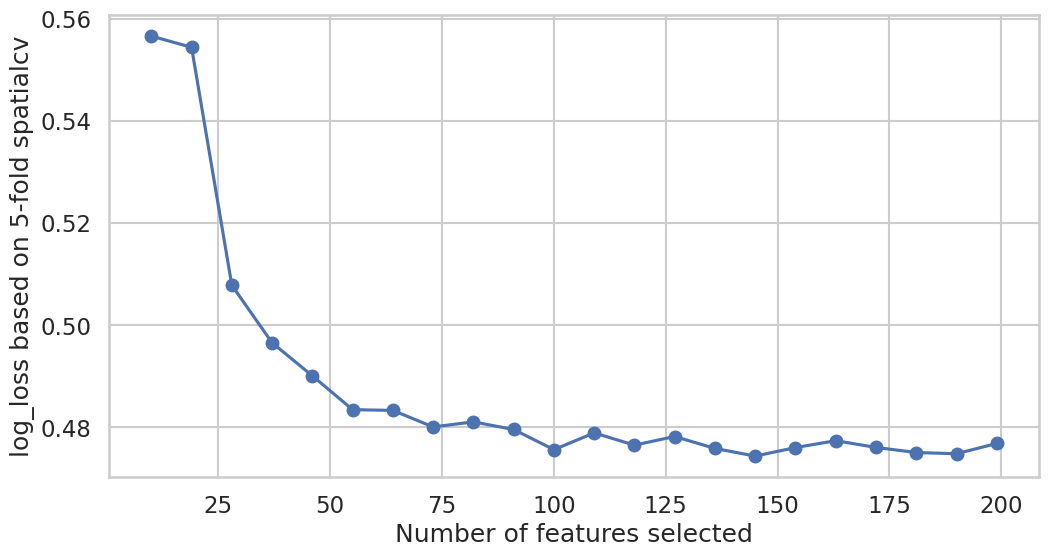

In [256]:
import matplotlib.pyplot as plt
rfecv_step = int(len(covs) * 0.05)
plt.figure(figsize=(12,6))
plt.xlabel("Number of features selected")
plt.ylabel("log_loss based on 5-fold spatialcv")
#plt.plot(range(10, len(covs)+rfecv_step, rfecv_step), rfecv_mean_score * -1, linestyle='-', marker='o')
plt.plot(range(10, 191+10, 9), rfecv_mean_score * -1, linestyle='-', marker='o')
#plt.plot(range(10, len(covs)+10, 10), rfecv_mean_score * -1)
#plt.xticks(range(rfecv.min_features_to_select, len(covs)+rfecv.step, rfecv.step))
plt.show()

In [233]:
#max_resources_rf = int(data_sub.shape[0] * 0.20)
#max_resources_xb = int(max_resources_rf / 2)
#if max_resources_rf < 20000 and data_sub.shape[0] >= 20000:
#    max_resources_rf = 20000
#    max_resources_xb = 20000
#if max_resources_rf < 1000:
#    max_resources_rf = data_sub.shape[0]
#    max_resources_xb = data_sub.shape[0]

In [10]:
data_sub = data.sample(100000, random_state=1989)
calibration_idx = data_sub.sample(10000).index

In [11]:
data_sub.index.isin(calibration_idx)

array([False, False, False, ..., False, False, False])

10000

In [15]:
from skmap.mapper import build_ann
from skmap.mapper import LandMapper
from eumap.misc import ttprint
from pathlib import Path
from scipy.signal import argrelmin
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv 
from sklearn.feature_selection import RFECV, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GroupKFold, KFold
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from scipy.stats import uniform, randint
import joblib
import multiprocessing
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import sys
import xgboost as xgb

def log_loss_scorer(clf, X, y_true):
    class_labels = clf.classes_
    y_pred_proba = clf.predict_proba(X)
    error = log_loss(y_true, y_pred_proba, labels=class_labels)
    return error * -1

estimator_rf = RandomForestClassifier(n_jobs=-1, n_estimators=60)

param_distributions = {
    "criterion": [ "gini", "entropy"],
    "max_depth": randint(5, 100),
    "max_features": uniform(loc=0, scale=1),
    "min_samples_split": randint(2, 40),
    "min_samples_leaf": randint(1, 10),
    "class_weight": [None, "balanced", "balanced_subsample" ]
}

hyperpar_rf = HalvingRandomSearchCV(
    estimator = estimator_rf,
    scoring = 'neg_log_loss',
    param_distributions = param_distributions,
    factor = 2,
    verbose = 1,
    min_resources = 500,
    max_resources = 20000,
    cv = GroupKFold(cv_folds),
    random_state=seed
)

estimator_xb = xgb.XGBClassifier(n_jobs=-1, objective='multi:softmax', booster='gbtree', 
    use_label_encoder=False, eval_metric='mlogloss', random_state=seed)

param_distributions = {
    "tree_method": ['hist', 'approx'],
    "grow_policy": ['depthwise', 'lossguide'],
    "alpha": uniform(loc=0, scale=2),
    "reg_alpha": uniform(loc=0, scale=0.2),
    "eta": uniform(loc=0, scale=2),
    "reg_lambda": uniform(loc=0, scale=0.2),
    "gamma": uniform(loc=0, scale=2),
    "subsample": uniform(loc=0.5, scale=0.5),
    "learning_rate": uniform(loc=0, scale=0.2),
    "colsample_bytree": uniform(loc=0, scale=1),
    "colsample_bylevel": uniform(loc=0, scale=1),
    "colsample_bynode": uniform(loc=0, scale=1),
    "max_depth": randint(10, 100),
    "n_estimators": randint(10, 60)
}

hyperpar_xb = HalvingRandomSearchCV(
    estimator = estimator_xb,
    scoring = 'neg_log_loss',
    param_distributions = param_distributions,
    factor = 2,
    verbose = 1,
    min_resources = 500,
    max_resources = 20000,
    cv = GroupKFold(cv_folds), 
    random_state=seed
)

from sklearn.neural_network import MLPClassifier

net = MLPClassifier(
    max_iter=100, 
    random_state=1989, 
    early_stopping=True, 
    n_iter_no_change=5,
    verbose=True
)

estimator_ann = Pipeline([
    ('scaler', StandardScaler()),
    ('estimator', net),
])

param_distributions = {
    "estimator__hidden_layer_sizes": [ (i,j) for i in range(4,8) for j in range(32,256,32) ],
    "estimator__batch_size": randint(32, 256),
    "estimator__learning_rate_init": uniform(loc=0.0001, scale=0.001),
    "estimator__activation": ['logistic', 'relu'],
    "estimator__alpha": uniform(loc=0.0001, scale=0.00005),
    "estimator__learning_rate": ['constant', 'adaptive'],
    "estimator__beta_1": uniform(loc=0.65, scale=0.30),
    "estimator__beta_2": uniform(loc=0.65, scale=0.30),
    "estimator__epsilon": uniform(loc=1e-8, scale=1e-9),
    "estimator__solver": ['adam']
}

hyperpar_ann = HalvingRandomSearchCV(
    estimator = estimator_ann,
    scoring = 'neg_log_loss',
    param_distributions = param_distributions,
    factor = 2,
    verbose = 1,
    min_resources = 500,
    max_resources = len(calibration_idx),
    cv = GroupKFold(cv_folds), 
    random_state=seed
)
# LandMapper
cv_method = GroupKFold(cv_folds)

#estimator_list = [estimator_rf, estimator_xb, estimator_ann]
#hyperpar_selection_list = [hyperpar_rf, hyperpar_xb, None]

m = LandMapper(points=data_sub, 
    calibration_idx = calibration_idx,
    feat_cols = covs, 
    target_col = target_column, 
    estimator = estimator_ann,
    hyperpar_selection = hyperpar_ann,
    #estimator = estimator_xb, 
    #hyperpar_selection = hyperpar_xb,
    cv = cv_method,
    cv_njobs=int(cv_njobs),
    pred_method='predict_proba',
    #weight_col=weight_column,
    feature_weights=feature_weights,
    cv_group_col = spatial_cv_column,
    n_jobs = 10,
    verbose = True)

m.train()

calibration_mask = (100000,))
[16:34:27] Transforming class:
[16:34:27]  -Original classes: [1. 2. 3.]
[16:34:27]  -Transformed classes: [0 1 2]
[16:34:27] Optimizing hyperparameters for Pipeline


/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 500
max_resources_: 10000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 20
n_resources: 500
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Iteration 3, loss = 0.72198434
Validation score: 0.739062
Iteration 4, loss = 0.70237465
Validation score: 0.756250
Iteration 5, loss = 0.68065586
Validation score: 0.743750
Iteration 6, loss = 0.65980110
Validation score: 0.759375
Iteration 7, loss = 0.64195572
Validation score: 0.756250
Iteration 8, loss = 0.62745414
Validation score: 0.771875
Iteration 9, loss = 0.61811410
Validation score: 0.776563
Iteration 10, loss = 0.61116353
Validation score: 0.778125
Iteration 11, loss = 0.60523412
Validation score: 0.789062
Iteration 12, loss = 0.60043585
Validation score: 0.792188
Iteration 13, loss = 0.59470637
Validation score: 0.778125
Iteration 14, loss = 0.59012132
Validation score: 0.776563
Iteration 15, loss = 0.58804926
Vali

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Validation score: 0.731250
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.
Iteration 1, loss = 1.17256885
Validation score: 0.362500
Iteration 2, loss = 0.99576775
Validation score: 0.668750
Iteration 3, loss = 0.89918955
Validation score: 0.693750
Iteration 4, loss = 0.83511374
Validation score: 0.693750
Iteration 5, loss = 0.77727884
Validation score: 0.706250
Iteration 6, loss = 0.73586524
Validation score: 0.712500
Iteration 7, loss = 0.71549750
Validation score: 0.700000
Iteration 8, loss = 0.70341820
Validation score: 0.700000
Iteration 9, loss = 0.69367976
Validation score: 0.693750
Iteration 10, loss = 0.68710853
Validation score: 0.693750
Iteration 11, loss = 0.68216560
Validation score: 0.700000
Iteration 12, loss = 0.67710523
Validation score: 0.712500
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.
Iteration 1, loss = 1.11493374
Validation score: 0.618750
Iteration 2, loss = 0.92583116
V

[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   15.1s remaining:   22.6s


[16:35:01] Training Pipeline using all samples


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   22.9s finished


Iteration 1, loss = 0.65305761
Validation score: 0.738500
Iteration 2, loss = 0.57394233
Validation score: 0.759300
Iteration 3, loss = 0.55147800
Validation score: 0.768800
Iteration 4, loss = 0.53897923
Validation score: 0.777500
Iteration 5, loss = 0.52990009
Validation score: 0.778300
Iteration 6, loss = 0.52310168
Validation score: 0.776000
Iteration 7, loss = 0.51781287
Validation score: 0.786200
Iteration 8, loss = 0.51311315
Validation score: 0.789900
Iteration 9, loss = 0.50861829
Validation score: 0.786300
Iteration 10, loss = 0.50641647
Validation score: 0.790800
Iteration 11, loss = 0.50334757
Validation score: 0.791400
Iteration 12, loss = 0.49986787
Validation score: 0.791800
Iteration 13, loss = 0.49881348
Validation score: 0.787100
Iteration 14, loss = 0.49631819
Validation score: 0.792500
Iteration 15, loss = 0.49504176
Validation score: 0.797600
Iteration 16, loss = 0.49370189
Validation score: 0.795000
Iteration 17, loss = 0.49210780
Validation score: 0.798100
Iterat

In [166]:
list(covs_rfe)

['red_glad.SeasConv.ard2_m_30m_s_0701_0831_go_epsg.4326_v20230908',
 'nir_glad.SeasConv.ard2_m_30m_s_0301_0430_go_epsg.4326_v20230908',
 'swir1_glad.SeasConv.ard2_m_30m_s_0501_0630_go_epsg.4326_v20230908',
 'green_glad.SeasConv.ard2_m_30m_s_0701_0831_go_epsg.4326_v20230908',
 'nir_glad.SeasConv.ard2_m_30m_s_0501_0630_go_epsg.4326_v20230908',
 'swir1_glad.SeasConv.ard2_m_30m_s_0301_0430_go_epsg.4326_v20230908',
 'swir1_glad.SeasConv.ard2_m_30m_s_0701_0831_go_epsg.4326_v20230908',
 'swir2_glad.SeasConv.ard2_m_30m_s_0701_0831_go_epsg.4326_v20230908',
 'swir2_glad.SeasConv.ard2_m_30m_s_0501_0630_go_epsg.4326_v20230908',
 'clm_lst_mod11a2.daytime.m11_p50_1km_s0..0cm_2000..2021_v1.2',
 'clm_lst_mod11a2.daytime.m03_sd_1km_s0..0cm_2000..2021_v1.2',
 'dtm_elevation_merit.dem_m_250m_s0..0cm_2017_v1.0',
 'clm_lst_mod11a2.nighttime.m07_p50_1km_s0..0cm_2000..2021_v1.2',
 'clm_lst_mod11a2.nighttime.m09_p50_1km_s0..0cm_2000..2021_v1.2',
 'clm_lst_mod11a2.daytime.m09_sd_1km_s0..0cm_2000..2021_v1.2',
 

In [17]:
wei_mask = (m.pts[weight_column] >= 1)
print(metrics.classification_report(
    m.target[wei_mask],
    np.argmax(m.eval_pred[wei_mask], axis=1)
))

              precision    recall  f1-score   support

           0       0.57      0.43      0.49     10061
           1       0.65      0.62      0.64     23974
           2       0.83      0.87      0.85     65965

    accuracy                           0.77    100000
   macro avg       0.68      0.64      0.66    100000
weighted avg       0.76      0.77      0.76    100000



In [259]:
from skmap.mapper import LandMapper
m = LandMapper.load_instance('model_v20240210/landmapper_sub.lz4')

In [260]:
m.pts['dataset_name'].unique()

array(['GPW', 'WorldCereal', 'Predicts', 'Cropharvest'], dtype=object)

In [275]:
m.pts['imagery'].unique()

array(['Bing', 'Google', 'Google / Bing', 'NA'], dtype=object)

In [276]:
gpw_mask = np.logical_and(m.pts['dataset_name'] == 'GPW', m.pts['imagery'] == 'Google / Bing')
wce_mask = m.pts['dataset_name'] == 'WorldCereal'
pre_mask = m.pts['dataset_name'] == 'Predicts'
crh_mask = m.pts['dataset_name'] == 'Cropharvest'

In [274]:
from sklearn import metrics
print(metrics.classification_report(
    np.argmax(m.eval_pred, axis=-1), m.target)
)
print(metrics.confusion_matrix(
    np.argmax(m.eval_pred, axis=-1), m.target, normalize='all')
)

              precision    recall  f1-score   support

           0       0.76      0.83      0.80   1360549
           1       0.64      0.75      0.69    512801
           2       0.91      0.86      0.89   3836296

    accuracy                           0.85   5709646
   macro avg       0.77      0.81      0.79   5709646
weighted avg       0.85      0.85      0.85   5709646

[[0.19871477 0.00384787 0.03572691]
 [0.0042232  0.06693392 0.01865597]
 [0.05716081 0.03462264 0.5801139 ]]


In [277]:
from sklearn import metrics
print("GPW")
print(metrics.classification_report(
    np.argmax(m.eval_pred, axis=-1)[gpw_mask], m.target[gpw_mask])
)
print(metrics.confusion_matrix(
    np.argmax(m.eval_pred, axis=-1)[gpw_mask], m.target[gpw_mask])
)

GPW
              precision    recall  f1-score   support

           0       0.36      0.74      0.49     18009
           1       0.66      0.74      0.70     55029
           2       0.94      0.84      0.89    244037

    accuracy                           0.82    317075
   macro avg       0.65      0.77      0.69    317075
weighted avg       0.86      0.82      0.83    317075

[[ 13348   2236   2425]
 [  3256  40719  11054]
 [ 20218  19019 204800]]


In [263]:
from sklearn import metrics
print("GPW")
print(metrics.classification_report(
    np.argmax(m.eval_pred, axis=-1)[gpw_mask], m.target[gpw_mask])
)
print(metrics.confusion_matrix(
    np.argmax(m.eval_pred, axis=-1)[gpw_mask], m.target[gpw_mask])
)

GPW
              precision    recall  f1-score   support

           0       0.32      0.69      0.43     99836
           1       0.66      0.75      0.70    499582
           2       0.92      0.83      0.88   1780070

    accuracy                           0.81   2379488
   macro avg       0.64      0.75      0.67   2379488
weighted avg       0.84      0.81      0.82   2379488

[[  68497   14446   16893]
 [  23418  372462  103702]
 [ 123217  173592 1483261]]


In [267]:
from sklearn import metrics
print("WorldCereal")
print(metrics.classification_report(
    np.argmax(m.eval_pred, axis=-1)[pre_mask], m.target[pre_mask])
)

WorldCereal
              precision    recall  f1-score   support

           0       0.15      0.42      0.22       798
           1       0.00      0.00      0.00       950
           2       0.93      0.89      0.91     12868

    accuracy                           0.81     14616
   macro avg       0.36      0.44      0.38     14616
weighted avg       0.83      0.81      0.81     14616



/home/opengeohub/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/opengeohub/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/opengeohub/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [268]:
from sklearn import metrics
print("Predicts")
print(metrics.classification_report(
    np.argmax(m.eval_pred, axis=-1)[crh_mask], m.target[crh_mask])
)

Predicts
              precision    recall  f1-score   support

           0       0.05      0.30      0.08       136
           1       0.01      0.33      0.02         9
           2       0.99      0.88      0.93      9478

    accuracy                           0.87      9623
   macro avg       0.35      0.51      0.35      9623
weighted avg       0.98      0.87      0.92      9623



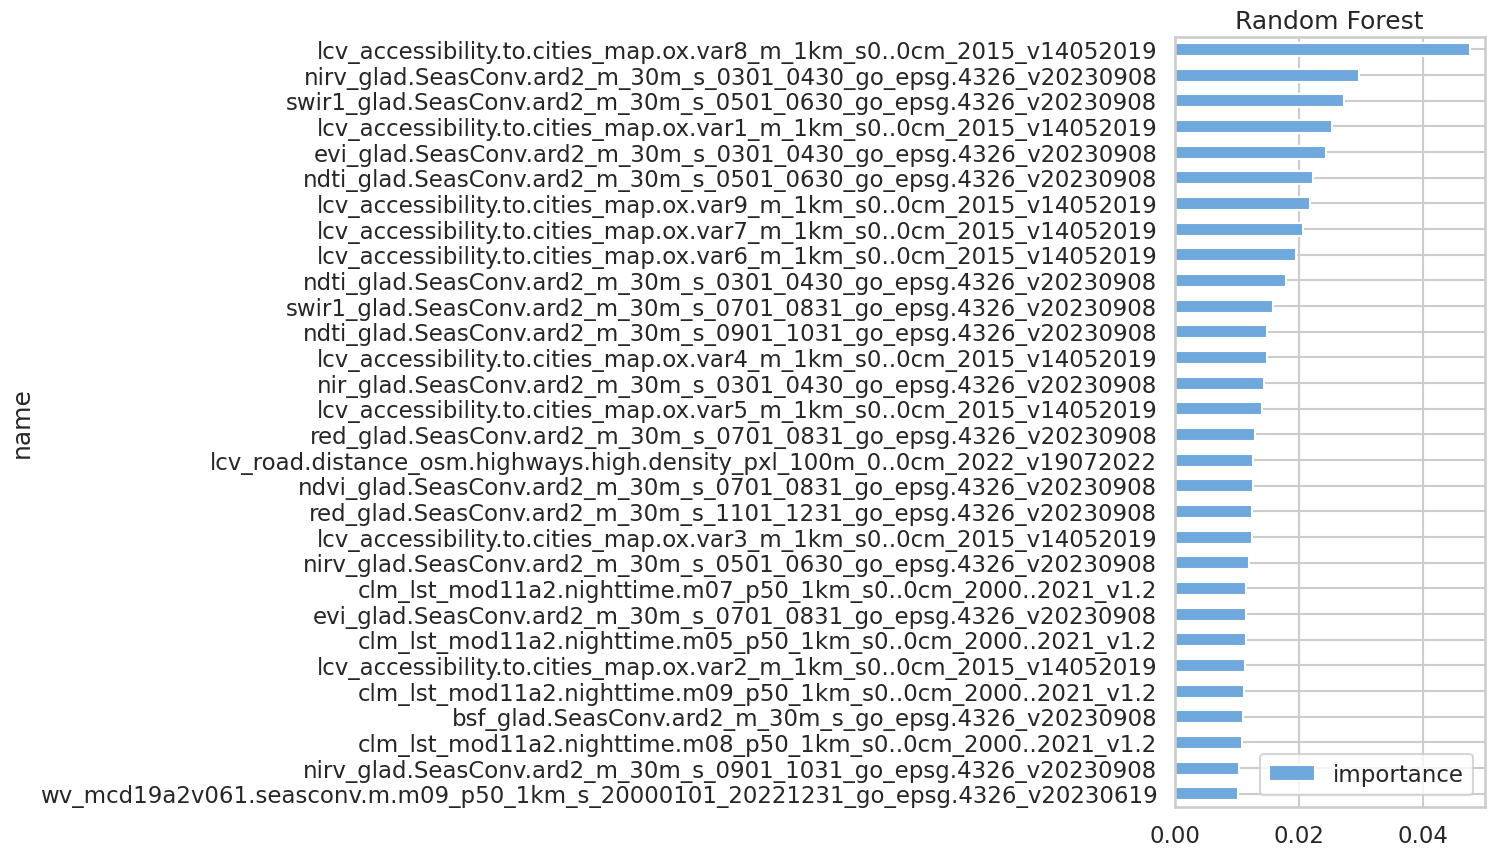

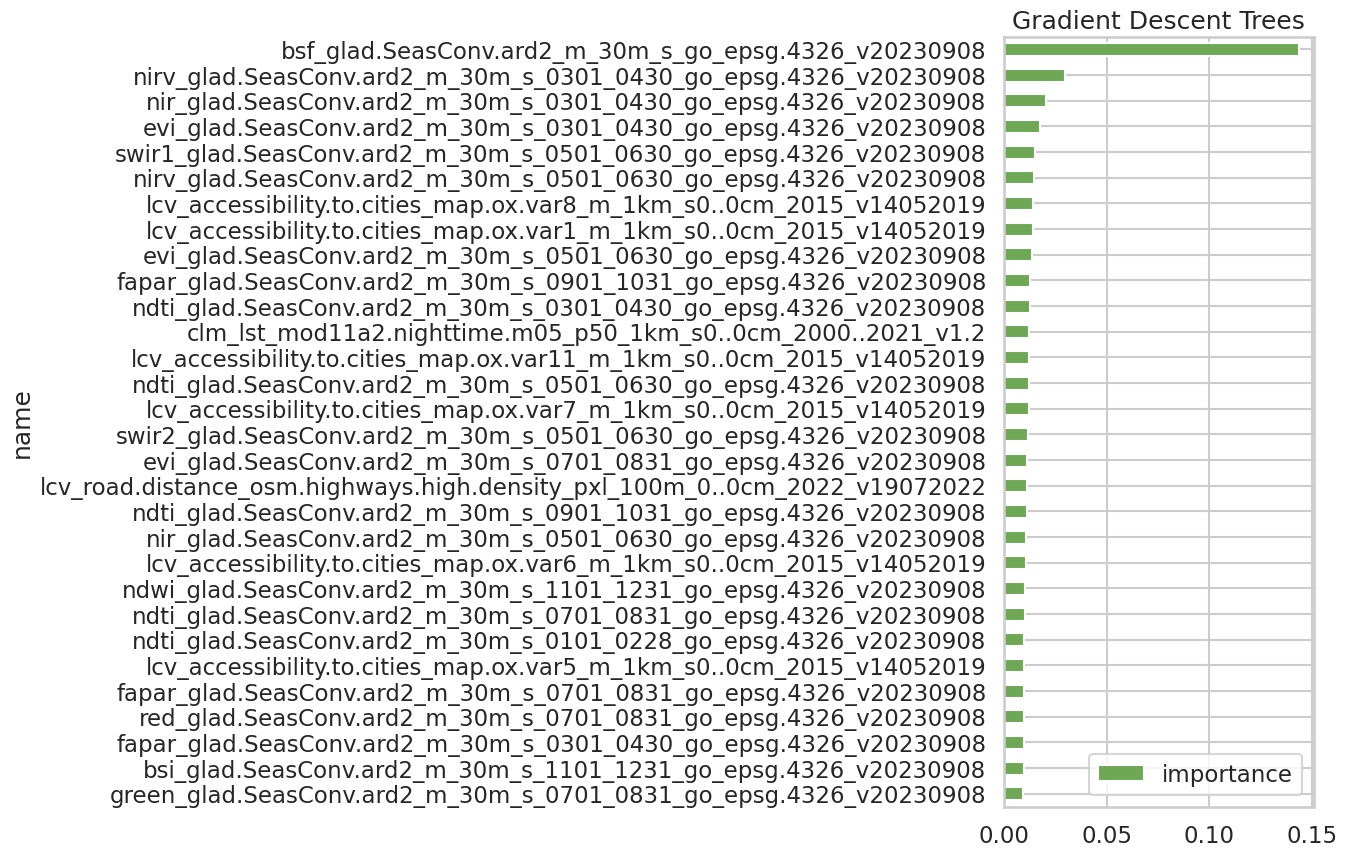

In [269]:
def plot_var_imp(feature_cols, estimator, title, top_n = 20, figsize=(4,10), color = 'blue'):
    var_imp = pd.DataFrame({'name':feature_cols, 'importance': estimator.feature_importances_})
    var_imp.index = var_imp['name']
    var_imp.sort_values('importance', ascending=False)[0:top_n].sort_values('importance').plot(kind = 'barh', figsize=figsize, title = title, color = color)

plot_var_imp(m.feature_cols, m.estimator_list[0], 'Random Forest', 30, color='#6fa8dd')
plot_var_imp(m.feature_cols, m.estimator_list[1], 'Gradient Descent Trees', 30, color='#6fa855')

In [270]:
len(m.feature_cols)

100

In [17]:
## XGB v1.1 tunning
wei_mask = (m.pts[weight_column] >= 1)
print(metrics.classification_report(
    m.target[wei_mask],
    np.argmax(m.eval_pred[wei_mask], axis=1)
))

              precision    recall  f1-score   support

           0       0.70      0.35      0.47     18751
           1       0.73      0.63      0.68     45317
           2       0.82      0.92      0.86    123103

    accuracy                           0.79    187171
   macro avg       0.75      0.63      0.67    187171
weighted avg       0.78      0.79      0.78    187171



In [40]:
## XGB final tunning
wei_mask = (m.pts[weight_column] >= 1)
print(metrics.classification_report(
    m.target[wei_mask],
    np.argmax(m.eval_pred[wei_mask], axis=1)
))

              precision    recall  f1-score   support

           0       0.68      0.30      0.42     18751
           1       0.72      0.62      0.67     45317
           2       0.81      0.92      0.86    123103

    accuracy                           0.78    187171
   macro avg       0.74      0.61      0.65    187171
weighted avg       0.77      0.78      0.77    187171



In [9]:
## XGB final tunning
wei_mask = (m.pts[weight_column] >= 1)
print(metrics.classification_report(
    m.target[wei_mask],
    np.argmax(m.eval_pred[wei_mask], axis=1)
))

              precision    recall  f1-score   support

           0       0.70      0.35      0.46     18751
           1       0.73      0.63      0.68     45317
           2       0.82      0.92      0.86    123103

    accuracy                           0.79    187171
   macro avg       0.75      0.63      0.67    187171
weighted avg       0.78      0.79      0.78    187171



In [27]:
wei_mask = (m.pts[weight_column] >= 1)
print(metrics.classification_report(
    m.target[wei_mask],
    np.argmax(m.eval_pred[wei_mask], axis=1)
))

              precision    recall  f1-score   support

           0       0.65      0.41      0.50      3186
           1       0.71      0.66      0.68     10131
           2       0.83      0.89      0.86     24918

    accuracy                           0.79     38235
   macro avg       0.73      0.65      0.68     38235
weighted avg       0.78      0.79      0.78     38235



In [19]:
wei_mask = (m.pts[weight_column] >= 1)
print(metrics.classification_report(
    m.target[wei_mask],
    np.argmax(m.eval_pred[wei_mask], axis=1)
))

              precision    recall  f1-score   support

           0       0.62      0.37      0.46    353861
           1       0.67      0.60      0.63    880396
           2       0.81      0.89      0.85   2360288

    accuracy                           0.77   3594545
   macro avg       0.70      0.62      0.65   3594545
weighted avg       0.76      0.77      0.76   3594545



## Final model

In [18]:
from skmap.mapper import build_ann
from skmap.mapper import LandMapper
from eumap.misc import ttprint
from pathlib import Path
from scipy.signal import argrelmin
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv 
from sklearn.feature_selection import RFECV, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GroupKFold, KFold
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from scipy.stats import uniform, randint
import joblib
import multiprocessing
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import sys
import xgboost as xgb

# weigths
#hyper_params = {
#    'alpha': 1.5763345281548804, 'colsample_bylevel': 0.7606314043395973, 
#    'colsample_bynode': 0.8485980810664047, 'colsample_bytree': 0.3648793180245271, 
#    'eta': 0.42623333984618483, 'gamma': 1.8992269631661898, 
#    'learning_rate': 0.11589894269711581, 'max_depth': 32, 
#    'n_estimators': 54, 'reg_alpha': 0.1915463635381925, 'reg_lambda': 0.17988499871922056
#}

# 1-km
#hyper_params = {
#    'alpha': 0.6861240288856107, 'colsample_bylevel': 0.9583437510471232, 
#    'colsample_bynode': 0.3300962432714286, 'colsample_bytree': 0.5395037254240045, 
#    'eta': 1.0746932445779167, 'gamma': 1.7577323485312526, 
#    'learning_rate': 0.10071430460941982, 'max_depth': 75, 
#    'n_estimators': 51, 'reg_alpha': 0.055707675853048394, 'reg_lambda': 0.08870765254290161
#}

#hyper_params = {
#    'alpha': 1.5763345281548804, 'colsample_bylevel': 0.7606314043395973, 
#    'colsample_bynode': 0.8485980810664047, 'colsample_bytree': 0.3648793180245271, 
#    'eta': 0.42623333984618483, 'gamma': 1.8992269631661898, 
#    'learning_rate': 0.11589894269711581, 'max_depth': 32, 'n_estimators': 54, 
#    'reg_alpha': 0.1915463635381925, 'reg_lambda': 0.17988499871922056
#}

#v1.1
hyper_params = {
    'alpha': 1.8315607097815743, 'colsample_bylevel': 0.23794734084872426, 
    'colsample_bynode': 0.3281409271441178, 'colsample_bytree': 0.7209428765163443, 
    'eta': 0.2667729521881883, 'gamma': 0.8148055697575725, 'grow_policy': 'depthwise', 
    'learning_rate': 0.09195868513103292, 'max_depth': 78, 'n_estimators': 54, 
    'reg_alpha': 0.16815411895809507, 'reg_lambda': 0.14973081916773653, 
    'subsample': 0.614074848764318, 'tree_method': 'approx'
}

estimator_xb = xgb.XGBClassifier(n_jobs=-1, objective='multi:softmax', booster='gbtree', 
    use_label_encoder=False, eval_metric='mlogloss', random_state=seed, **hyper_params)

#hyper_params = {
#    'class_weight': None, 'criterion': 'entropy', 
#    'max_depth': 56, 'max_features': 0.18071376213913193, 
#    'min_samples_leaf': 7, 'min_samples_split': 37
#}

#estimator_rf = RandomForestClassifier(n_jobs=-1, n_estimators=60, **hyper_params)

m = LandMapper(points=data_train, 
    feat_cols = covs_rfe, 
    target_col = target_column, 
    estimator = estimator_xb, 
    cv = cv_method,
    cv_njobs=int(cv_njobs),
    pred_method='predict_proba',
    weight_col=weight_column,
    feature_weights=feature_weights,
    cv_group_col = spatial_cv_column,
    n_jobs = 10,
    verbose = True)

#m.train()

/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[13:33:10] Transforming class:
[13:33:11]  -Original classes: [1. 2. 3.]
[13:33:11]  -Transformed classes: [0 1 2]


In [19]:
m.train()

[13:33:11] Calculating evaluation metrics


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 155.9min remaining: 233.8min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 164.9min finished


[16:18:23] Training XGBClassifier using all samples


In [22]:
##
wei_mask = (m.pts[weight_column] >= 1)
print(metrics.classification_report(
    m.target[wei_mask],
    np.argmax(m.eval_pred[wei_mask], axis=1)
))

              precision    recall  f1-score   support

           0       0.73      0.29      0.42    935841
           1       0.75      0.59      0.66   2257889
           2       0.80      0.94      0.86   6135391

    accuracy                           0.79   9329121
   macro avg       0.76      0.60      0.65   9329121
weighted avg       0.78      0.79      0.77   9329121



In [21]:
fn_landmapper =  'global_model_v1.1.lz4' 
m.save_instance(fn_landmapper)

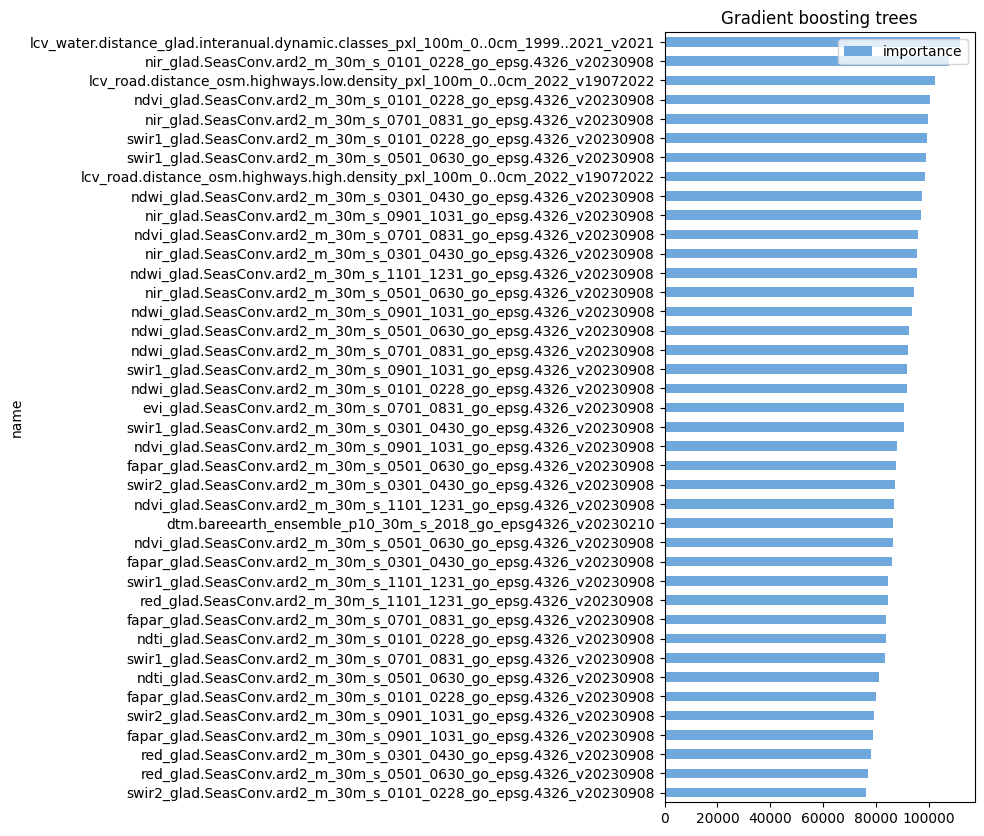

In [35]:
# “gain”, “weight”, “cover”, “total_gain” or “total_cover”.
# ‘weight’ - the number of times a feature is used to split the data across all trees.
# ‘gain’ - the average gain across all splits the feature is used in.
# ‘cover’ - the average coverage across all splits the feature is used in.
# ‘total_gain’ - the total gain across all splits the feature is used in.
# ‘total_cover’ - the total coverage across all splits the feature is used in.

def plot_var_imp(feature_cols, estimator, title, top_n = 20, figsize=(4,10), color = 'blue'):
    #var_imp = pd.DataFrame({'name':feature_cols, 'importance': list(m.estimator_list[0].feature_importances_)})
    var_imp = pd.DataFrame({'name':feature_cols, 'importance': list(m.estimator_list[0].get_booster().get_score(importance_type="weight").values())})
    
    var_imp.index = var_imp['name']
    var_imp.sort_values('importance', ascending=False)[0:top_n].sort_values('importance').plot(kind = 'barh', figsize=figsize, title = title, color = color)

plot_var_imp(m.feature_cols, m.estimator_list[0], 'Gradient boosting trees', 40, color='#6fa8dd')

In [49]:
fn_landmapper =  'global_model_v1.1.lz4' 
m.save_instance(fn_landmapper)

## Prediction Optimization

### sklearn-onnx

In [2]:
import numpy as np
test_input = np.empty((16000000, m.features.shape[1]))

In [8]:
from skl2onnx import to_onnx
onx_rf = to_onnx(m.estimator_list[0], m.features[:1])

In [9]:
with open("opt_models/rf.onnx", "wb") as f:
    f.write(onx_rf.SerializeToString())

In [13]:
from onnxmltools.convert.xgboost.operator_converters.XGBoost import convert_xgboost
from onnxmltools.convert import convert_xgboost as convert_xgboost_booster
from skl2onnx.common.shape_calculator import (
    calculate_linear_classifier_output_shapes,
    calculate_linear_regressor_output_shapes,
)

from xgboost import XGBClassifier
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import convert_sklearn, to_onnx, update_registered_converter

update_registered_converter(
    XGBClassifier,
    "XGBoostXGBClassifier",
    calculate_linear_classifier_output_shapes,
    convert_xgboost,
    options={"nocl": [True, False], "zipmap": [True, False, "columns"]},
)

onx_xgb = to_onnx(m.estimator_list[1], m.features[:1])

In [14]:
with open("opt_models/xgb.onnx", "wb") as f:
    f.write(onx_xgb.SerializeToString())

In [15]:
from skl2onnx import to_onnx
onx_ann = to_onnx(m.estimator_list[2], m.features[:1])

In [17]:
with open("opt_models/ann.onnx", "wb") as f:
    f.write(onx_ann.SerializeToString())

In [24]:
%%time
import onnxruntime as rt

#sess = rt.InferenceSession("opt_models/xgb.onnx", providers=["CPUExecutionProvider"])
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name
pred_onx = sess.run([label_name], {input_name: m.features.astype(np.float32)})[0]
pred_onx

CPU times: user 4min 58s, sys: 13.1 s, total: 5min 11s
Wall time: 25.8 s


array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

### Hummingbird

In [66]:
torch.jit.__name__

'torch.jit'

In [67]:
from hummingbird.ml import convert
import torch
estimator_xgb_hb = convert(m.estimator_list[1], torch.jit.__name__, test_input[0:1])


KeyboardInterrupt



In [4]:
import torch
torch.jit.__name__

'torch.jit'

In [2]:
pip install tl2cgen


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.9 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.7/198.7 kB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 87.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


### Estimators

In [2]:
from skmap.mapper import LandMapper
fn_landmapper =  'global_model_eml_v1.2.lz4' #'global_model_v1.lz4'
m = LandMapper.load_instance(fn_landmapper)

In [3]:
import numpy as np
test_pred = np.concatenate([m.features, m.features], axis=0)[0:16000000,:]

### RF

In [ ]:
#!pip install git+https://github.com/ajtulloch/sklearn-compiledtrees.git
#https://www.intel.com/content/www/us/en/developer/articles/tool/oneapi-standalone-components.html#dpcpp-cpp

In [1]:
import compiledtrees

In [4]:
from compiledtrees import _compiled
from compiledtrees import code_gen as cg
from compiledtrees import CompiledClassifierPredictor
from pathlib import Path

def _build(cls, clf, n_jobs=1):
    n_features = clf.n_features_

    so_f = Path('/tmp/compiledtrees_byxjqx8w.so')
    print(so_f.name.encode("ascii"))
    print(cg.EVALUATE_FN_NAME.encode("ascii"))
    evaluator = _compiled.CompiledClassifier(
        so_f.name.encode("ascii"),
        cg.EVALUATE_FN_NAME.encode("ascii"))
    return n_features, evaluator, so_f

CompiledClassifierPredictor._build = _build

In [ ]:
import compiledtrees
m.estimator_list[0].n_features_ = m.estimator_list[0].n_features_in_
compiled_predictor = compiledtrees.CompiledClassifierPredictor(m.estimator_list[0])
#predictions = compiled_predictor.predict(X_test)

In [1]:
compiled_predictor

NameError: name 'compiled_predictor' is not defined

In [22]:
from hummingbird.ml import convert
estimator_rf_hb_tvm = convert(m.estimator_list[0], 'tvm', test_pred, device='llvm -mcpu=cascadelake', extra_config={'tvm_max_fuse_depth': 120, 'tree_implementation': 'tree_trav'})

TVMError: Traceback (most recent call last):
  7: TVMFuncCall
  6: tvm::runtime::PackedFuncObj::Extractor<tvm::runtime::PackedFuncSubObj<tvm::runtime::TypedPackedFunc<tvm::IRModule (tvm::transform::Pass, tvm::IRModule)>::AssignTypedLambda<tvm::transform::{lambda(tvm::transform::Pass, tvm::IRModule)#7}>(tvm::transform::{lambda(tvm::transform::Pass, tvm::IRModule)#7}, std::string)::{lambda(tvm::runtime::TVMArgs const&, tvm::runtime::TVMRetValue*)#1}> >::Call(tvm::runtime::PackedFuncObj const*, tvm::runtime::TVMArgs, tvm::runtime::TVMRetValue*)
  5: tvm::transform::Pass::operator()(tvm::IRModule) const
  4: tvm::transform::Pass::operator()(tvm::IRModule, tvm::transform::PassContext const&) const
  3: tvm::transform::ModulePassNode::operator()(tvm::IRModule, tvm::transform::PassContext const&) const
  2: tvm::runtime::PackedFuncObj::Extractor<tvm::runtime::PackedFuncSubObj<tvm::runtime::TypedPackedFunc<tvm::IRModule (tvm::IRModule, tvm::transform::PassContext)>::AssignTypedLambda<tvm::relay::transform::InferType()::{lambda(tvm::IRModule, tvm::transform::PassContext const&)#1}>(tvm::relay::transform::InferType()::{lambda(tvm::IRModule, tvm::transform::PassContext const&)#1})::{lambda(tvm::runtime::TVMArgs const&, tvm::runtime::TVMRetValue*)#1}> >::Call(tvm::runtime::PackedFuncObj const*, tvm::runtime::TVMArgs, tvm::runtime::TVMRetValue*)
  1: tvm::relay::TypeInferencer::Infer(tvm::GlobalVar, tvm::relay::Function)
  0: tvm::relay::TypeSolver::Solve() [clone .cold]
  10: TVMFuncCall
  9: tvm::runtime::PackedFuncObj::Extractor<tvm::runtime::PackedFuncSubObj<tvm::runtime::TypedPackedFunc<tvm::IRModule (tvm::transform::Pass, tvm::IRModule)>::AssignTypedLambda<tvm::transform::{lambda(tvm::transform::Pass, tvm::IRModule)#7}>(tvm::transform::{lambda(tvm::transform::Pass, tvm::IRModule)#7}, std::string)::{lambda(tvm::runtime::TVMArgs const&, tvm::runtime::TVMRetValue*)#1}> >::Call(tvm::runtime::PackedFuncObj const*, tvm::runtime::TVMArgs, tvm::runtime::TVMRetValue*)
  8: tvm::transform::Pass::operator()(tvm::IRModule) const
  7: tvm::transform::Pass::operator()(tvm::IRModule, tvm::transform::PassContext const&) const
  6: tvm::transform::ModulePassNode::operator()(tvm::IRModule, tvm::transform::PassContext const&) const
  5: tvm::runtime::PackedFuncObj::Extractor<tvm::runtime::PackedFuncSubObj<tvm::runtime::TypedPackedFunc<tvm::IRModule (tvm::IRModule, tvm::transform::PassContext)>::AssignTypedLambda<tvm::relay::transform::InferType()::{lambda(tvm::IRModule, tvm::transform::PassContext const&)#1}>(tvm::relay::transform::InferType()::{lambda(tvm::IRModule, tvm::transform::PassContext const&)#1})::{lambda(tvm::runtime::TVMArgs const&, tvm::runtime::TVMRetValue*)#1}> >::Call(tvm::runtime::PackedFuncObj const*, tvm::runtime::TVMArgs, tvm::runtime::TVMRetValue*)
  4: tvm::relay::TypeInferencer::Infer(tvm::GlobalVar, tvm::relay::Function)
  3: tvm::relay::TypeSolver::Solve()
  2: _ZN3tvm7runtime13PackedFun
  1: tvm::runtime::TypedPackedFunc<bool (tvm::runtime::Array<tvm::Type, void> const&, int, tvm::Attrs const&, tvm::TypeReporter const&)>::AssignTypedLambda<bool (*)(tvm::runtime::Array<tvm::Type, void> const&, int, tvm::Attrs const&, tvm::TypeReporter const&)>(bool (*)(tvm::runtime::Array<tvm::Type, void> const&, int, tvm::Attrs const&, tvm::TypeReporter const&))::{lambda(tvm::runtime::TVMArgs const&, tvm::runtime::TVMRetValue*)#1}::operator()(tvm::runtime::TVMArgs const&, tvm::runtime::TVMRetValue*) const
  0: tvm::relay::ReshapeRel(tvm::runtime::Array<tvm::Type, void> const&, int, tvm::Attrs const&, tvm::TypeReporter const&)
  File "/workspace/tvm/src/relay/analysis/type_solver.cc", line 624
TVMError: 
---------------------------------------------------------------
An error occurred during the execution of TVM.
For more information, please see: https://tvm.apache.org/docs/errors.html
---------------------------------------------------------------
  Check failed: (false) is false: [12:06:26] /workspace/tvm/src/relay/op/tensor/transform.cc:794: 
---------------------------------------------------------------
An error occurred during the execution of TVM.
For more information, please see: https://tvm.apache.org/docs/errors.html
---------------------------------------------------------------

  Check failed: oshape_sum == data_shape_sum (-1414967400 vs. 2880000000) : Input tensor shape(960000000,3) and reshaped shape(-7860930,60,3) are not compatible!


In [ ]:
# 10:30
estimator_rf_hb_tvm

#### ANN

In [5]:
#from hummingbird.ml import convert
#estimator_ann_hb_tvm = convert(m.estimator_list[2], 'tvm', test_pred, device='llvm -mcpu=cascadelake', extra_config={'tvm_max_fuse_depth': 100})

[10:04:23] /workspace/tvm/src/te/schedule/bound.cc:119: not in feed graph consumer = compute(p0_red_temp, body=[reduce(combiner=comm_reducer(result=[select(((argmax_lhs_1 > argmax_rhs_1) || ((argmax_lhs_1 == argmax_rhs_1) && (argmax_lhs_0 < argmax_rhs_0))), argmax_lhs_0, argmax_rhs_0), select((argmax_lhs_1 > argmax_rhs_1), argmax_lhs_1, argmax_rhs_1)], lhs=[argmax_lhs_0, argmax_lhs_1], rhs=[argmax_rhs_0, argmax_rhs_1], identity_element=[-1, -3.40282e+38f]), source=[k1, p0[ax0, k1]], init=[], axis=[iter_var(k1, range(min=0, ext=3))], where=(bool)1, value_index=0), reduce(combiner=comm_reducer(result=[select(((argmax_lhs_1 > argmax_rhs_1) || ((argmax_lhs_1 == argmax_rhs_1) && (argmax_lhs_0 < argmax_rhs_0))), argmax_lhs_0, argmax_rhs_0), select((argmax_lhs_1 > argmax_rhs_1), argmax_lhs_1, argmax_rhs_1)], lhs=[argmax_lhs_0, argmax_lhs_1], rhs=[argmax_rhs_0, argmax_rhs_1], identity_element=[-1, -3.40282e+38f]), source=[k1, p0[ax0, k1]], init=[], axis=[iter_var(k1, range(min=0, ext=3))], whe

In [6]:
#%%time
#test_re = estimator_ann_hb_tvm.predict_proba(test_pred)
#test_re.shape

CPU times: user 41.1 s, sys: 48 s, total: 1min 29s
Wall time: 16.1 s


(16000000, 3)

In [8]:
from hummingbird.ml import convert
estimator_ann_hb = convert(m.estimator_list[2], 'pytorch')

In [9]:
%%time
test_re = m.estimator_list[2].predict_proba(test_pred)
test_re.shape

CPU times: user 1min 16s, sys: 8.23 s, total: 1min 24s
Wall time: 20.5 s


(16000000, 3)

In [11]:
%%time
test_re = estimator_ann_hb.predict_proba(test_pred)
test_re.shape

CPU times: user 2min, sys: 3min 23s, total: 5min 23s
Wall time: 12 s


(16000000, 3)

### Meta-estimator

In [16]:
test_meta_pred = np.concatenate([m.meta_features, m.meta_features], axis=0)[0:16000000,:]
test_meta_pred.shape

(16000000, 9)

In [19]:
from hummingbird.ml import convert
estimator_met_hb = convert(m.meta_estimator, 'pytorch')

In [91]:
%%time
test_re_met = m.meta_estimator.predict_proba(test_meta_pred)
test_re_met.shape

CPU times: user 11.9 s, sys: 654 ms, total: 12.5 s
Wall time: 1.6 s


(16000000, 3)

In [92]:
%%time
test_re_met = estimator_met_hb.predict_proba(test_meta_pred)
test_re_met.shape

CPU times: user 7.06 s, sys: 2.3 s, total: 9.36 s
Wall time: 195 ms


(16000000, 3)

In [ ]:
estimator_xbg_hb = convert(m.estimator_list[1], 'tvm', test_input)

In [84]:
m.estimator_list[2] = estimator_ann_hb

In [87]:
#from skmap.mapper import LandMapper
m.save_instance('global_model_eml_v1.2_opt.lz4')

In [88]:
from skmap.mapper import LandMapper
fn_landmapper =  'global_model_eml_v1.2_opt.lz4' #'global_model_v1.lz4'
m2 = LandMapper.load_instance(fn_landmapper)

## Prediction

In [1]:
from skmap.mapper import LandMapper
fn_landmapper =  'global_model_eml_v1.2.lz4' #'global_model_v1.lz4'
m = LandMapper.load_instance(fn_landmapper)

In [228]:
from skmap.misc import find_files
#static_raster = find_files('./static', '*100m*.vrt') + find_files('./static', '*30m*.vrt')
static_raster = find_files('./static', '*.vrt')

In [229]:
static_raster

[PosixPath('static/.ipynb_checkpoints/lcv_accessibility.to.cities_map.ox.var12_m_1km_s0..0cm_2015_v14052019-checkpoint.vrt'),
 PosixPath('static/clm_lst_mod11a2.daytime.m02_p50_1km_s0..0cm_2000..2021_v1.2.vrt'),
 PosixPath('static/clm_lst_mod11a2.daytime.m02_sd_1km_s0..0cm_2000..2021_v1.2.vrt'),
 PosixPath('static/clm_lst_mod11a2.daytime.m03_p50_1km_s0..0cm_2000..2021_v1.2.vrt'),
 PosixPath('static/clm_lst_mod11a2.daytime.m03_sd_1km_s0..0cm_2000..2021_v1.2.vrt'),
 PosixPath('static/clm_lst_mod11a2.daytime.m04_p50_1km_s0..0cm_2000..2021_v1.2.vrt'),
 PosixPath('static/clm_lst_mod11a2.daytime.m04_sd_1km_s0..0cm_2000..2021_v1.2.vrt'),
 PosixPath('static/clm_lst_mod11a2.daytime.m05_p50_1km_s0..0cm_2000..2021_v1.2.vrt'),
 PosixPath('static/clm_lst_mod11a2.daytime.m05_sd_1km_s0..0cm_2000..2021_v1.2.vrt'),
 PosixPath('static/clm_lst_mod11a2.daytime.m06_p50_1km_s0..0cm_2000..2021_v1.2.vrt'),
 PosixPath('static/clm_lst_mod11a2.daytime.m06_sd_1km_s0..0cm_2000..2021_v1.2.vrt'),
 PosixPath('static/

In [19]:
import geopandas as gpd
tiles = gpd.read_file('ard2_final_status.gpkg')
tiles

,X_COORD,Y_COORD,TILE,n_images,geometry
0,-77.5,83.5,077W_83N,598,"MULTIPOLYGON (((-78.00000 84.00000, -77.00000 ..."
1,-76.5,83.5,076W_83N,598,"MULTIPOLYGON (((-77.00000 84.00000, -76.00000 ..."
2,-75.5,83.5,075W_83N,598,"MULTIPOLYGON (((-76.00000 84.00000, -75.00000 ..."
3,-74.5,83.5,074W_83N,598,"MULTIPOLYGON (((-75.00000 84.00000, -74.00000 ..."
4,-73.5,83.5,073W_83N,598,"MULTIPOLYGON (((-74.00000 84.00000, -73.00000 ..."
...,...,...,...,...,...
18662,-70.5,-55.5,070W_55S,598,"MULTIPOLYGON (((-71.00000 -55.00000, -70.00000..."
18663,-69.5,-55.5,069W_55S,598,"MULTIPOLYGON (((-70.00000 -55.00000, -69.00000..."
18664,-68.5,-55.5,068W_55S,598,"MULTIPOLYGON (((-69.00000 -55.00000, -68.00000..."
18665,-67.5,-55.5,067W_55S,598,"MULTIPOLYGON (((-68.00000 -55.00000, -67.00000..."


In [20]:
tile = '103E_46N'
bounds = tiles[tiles['TILE'] == tile].iloc[0].geometry.bounds

In [24]:
%%time
from skmap.misc import vrt_warp
vrt_files = vrt_warp(static_raster, dst_crs='EPSG:4326', tr=0.00025, te = bounds)

Warning 1: /vsicurl/http://192.168.49.41:8333/global/lcv/lcv_water.distance_glad.interanual.dynamic.classes_pxl_100m_0..0cm_1999..2021_v2021.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes
Warning 1: /vsicurl/http://192.168.49.41:8333/global/lcv/lcv_water.distance_glad.interanual.dynamic.classes_pxl_100m_0..0cm_1999..2021_v2021.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes


CPU times: user 659 ms, sys: 8.52 s, total: 9.18 s
Wall time: 9.55 s


In [22]:
vrt_files

['/tmp/skmap/tmpag65tcje/dtm.bareearth_ensemble_p10_30m_s_2018_go_epsg4326_v20230210-checkpoint.vrt',
 '/tmp/skmap/tmpag65tcje/lcv_road.distance_osm.highways.low.density_pxl_100m_0..0cm_2022_v19072022-checkpoint.vrt',
 '/tmp/skmap/tmpag65tcje/lcv_water.distance_glad.interanual.dynamic.classes_pxl_100m_0..0cm_1999..2021_v2021-checkpoint.vrt',
 '/tmp/skmap/tmpag65tcje/clm_lst_mod11a2.daytime.m02_p50_1km_s0..0cm_2000..2021_v1.2.vrt',
 '/tmp/skmap/tmpag65tcje/clm_lst_mod11a2.daytime.m02_sd_1km_s0..0cm_2000..2021_v1.2.vrt',
 '/tmp/skmap/tmpag65tcje/clm_lst_mod11a2.daytime.m03_p50_1km_s0..0cm_2000..2021_v1.2.vrt',
 '/tmp/skmap/tmpag65tcje/clm_lst_mod11a2.daytime.m03_sd_1km_s0..0cm_2000..2021_v1.2.vrt',
 '/tmp/skmap/tmpag65tcje/clm_lst_mod11a2.daytime.m04_p50_1km_s0..0cm_2000..2021_v1.2.vrt',
 '/tmp/skmap/tmpag65tcje/clm_lst_mod11a2.daytime.m04_sd_1km_s0..0cm_2000..2021_v1.2.vrt',
 '/tmp/skmap/tmpag65tcje/clm_lst_mod11a2.daytime.m05_p50_1km_s0..0cm_2000..2021_v1.2.vrt',
 '/tmp/skmap/tmpag65tc

from pathlib import Path
def _model_input(tile, year, bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermal'], base_url='http://192.168.49.30:8333'):
    prediction_layers = []
    
    for band in bands:
        prediction_layers += [
            f'{base_url}/prod-landsat-ard2/{tile}/seasconv/{band}_glad.SeasConv.ard2_m_30m_s_' + '{year}0101_{year}0228_go_epsg.4326_v20230908.tif',
            f'{base_url}/prod-landsat-ard2/{tile}/seasconv/{band}_glad.SeasConv.ard2_m_30m_s_' + '{year}0301_{year}0430_go_epsg.4326_v20230908.tif',
            f'{base_url}/prod-landsat-ard2/{tile}/seasconv/{band}_glad.SeasConv.ard2_m_30m_s_' + '{year}0501_{year}0630_go_epsg.4326_v20230908.tif',
            f'{base_url}/prod-landsat-ard2/{tile}/seasconv/{band}_glad.SeasConv.ard2_m_30m_s_' + '{year}0701_{year}0831_go_epsg.4326_v20230908.tif',
            f'{base_url}/prod-landsat-ard2/{tile}/seasconv/{band}_glad.SeasConv.ard2_m_30m_s_' + '{year}0901_{year}1031_go_epsg.4326_v20230908.tif',
            f'{base_url}/prod-landsat-ard2/{tile}/seasconv/{band}_glad.SeasConv.ard2_m_30m_s_' + '{year}1101_{year}1231_go_epsg.4326_v20230908.tif'
        ]
    
    raster_files = []
    dict_layers_newnames = {}
    for l in prediction_layers:
    
        key = Path(l).stem.replace('{year}', '')
        value = Path(l).stem.replace('{year}', str(year))
        dict_layers_newnames[key] = value
        raster_files.append(Path(l.replace('{year}', str(year))))
    
    return raster_files, dict_layers_newnames

#tile = '081E_60N'  #'081E_60N' '145E_18S'
#tile = '061W_28S' # Chaco
#tile = '003W_57N' # Scotland
#tile = '055W_28S' # RS - Brazil
#tile = '016E_12S' # Angola 
#tile = '055W_17S' # Pantanal
tile = '103E_46N' # Mongolia
#tile = '091W_17N' # Mexico
#tile = '029E_51N' # Ukraine
year = 2020
bounds = tiles[tiles['TILE'] == tile].iloc[0].geometry.bounds

raster_files, dict_layers_newnames = _model_input(tile, 2020)
raster_files += raster_files + static_raster
#m.predict(fn_layers=raster_files, fn_output=f'prediction_v1/{tile}/pasture.class_{year}.tif', bounds=bounds, allow_additional_layers=False, dict_layers_newnames=dict_layers_newnames, n_jobs_io=42)

In [41]:
from skmap.misc import vrt_warp
vrt_files = vrt_warp(raster_files, dst_crs='EPSG:4326', tr=0.00025, te = bounds)
vrt_files = [ Path(f) for f in vrt_files ]
print(vrt_files[0], len(vrt_files))

Warning 1: /vsicurl/http://192.168.49.41:8333/global/lcv/lcv_water.distance_glad.interanual.dynamic.classes_pxl_100m_0..0cm_1999..2021_v2021.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes


/tmp/skmap/tmpikfl2zre/blue_glad.SeasConv.ard2_m_30m_s_20200101_20200228_go_epsg.4326_v20230908.vrt 169


In [42]:
import numexpr as ne
import numpy as np

def inmem_calc_func(layernames, raster_data, bounds):
    import numexpr as ne
    
    lockup = dict(zip(layernames, range(0,raster_data.shape[1])))
    
    pref = 'glad.SeasConv.ard2_m_30m_s'
    suff = 'go_epsg.4326_v20230908'
    dates = ['0101_0228','0301_0430','0501_0630','0701_0831','0901_1031','1101_1231']
    bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermal']

    indices = {}

    for dt in dates:
        local_dict = { b: raster_data[:, :, lockup[f'{b}_{pref}_{dt}_{suff}']:lockup[f'{b}_{pref}_{dt}_{suff}']+1 ] for b in bands}
        indices[f'ndvi_{pref}_{dt}_{suff}'] = f'( ( (nir * 0.004) - (red * 0.004) ) / ( (nir * 0.004) + (red * 0.004) ) ) * 125 + 125', local_dict
        indices[f'ndwi_{pref}_{dt}_{suff}'] = f'( ( (nir * 0.004) - (swir1 * 0.004) ) / ( (nir * 0.004) + (swir1 * 0.004) ) ) * 125 + 125', local_dict
        #indices[f'savi_{pref}_{dt}_{suff}'] = f'( ( (nir * 0.004) - (red * 0.004) )*1.5 / ( (nir * 0.004) + (red * 0.004)  + 0.5) ) * 125 + 125', local_dict
        #indices[f'msavi_{pref}_{dt}_{suff}'] = f'( (2 *  (nir * 0.004) + 1 - sqrt((2 *  (nir * 0.004) + 1)**2 - 8 * ( (nir * 0.004) - (red * 0.004) ))) / 2 ) * 125 + 125', local_dict
        #indices[f'nbr_{pref}_{dt}_{suff}'] = f'( ( (nir * 0.004) - ( swir2 * 0.004) ) / ( (nir * 0.004) + ( swir2 * 0.004) ) ) * 125 + 125', local_dict
        #indices[f'ndmi_{pref}_{dt}_{suff}'] = f'( ( (nir * 0.004) -  (swir1 * 0.004)) / ( (nir * 0.004) +  (swir1 * 0.004)) ) * 125 + 125', local_dict
        #indices[f'nbr2_{pref}_{dt}_{suff}'] = f'( ( (swir1 * 0.004) - ( thermal * 0.004) ) / ( (swir1 * 0.004) + ( thermal * 0.004) ) ) * 125 + 125', local_dict
        #indices[f'rei_{pref}_{dt}_{suff}'] = f'( ( (nir * 0.004) - blue)/( (nir * 0.004) + blue *  (nir * 0.004)) ) * 125 + 125', local_dict
        indices[f'bsi_{pref}_{dt}_{suff}'] = f'( ( ( (swir1 * 0.004) + (red * 0.004) ) - ( (nir * 0.004) + blue) ) / ( ( (swir1 * 0.004) + (red * 0.004) ) + ( (nir * 0.004) + blue) ) ) * 125 + 125', local_dict
        indices[f'ndti_{pref}_{dt}_{suff}'] = f'( ( (swir1 * 0.004) - (swir2 * 0.004) )  / ( (swir1 * 0.004) + (swir2 * 0.004) )  ) * 125 + 125', local_dict
        #indices[f'ndsi_{pref}_{dt}_{suff}'] = f'( ( (green * 0.004) -  (swir1 * 0.004) ) / ( (green * 0.004) +  (swir1 * 0.004) ) ) * 125 + 125', local_dict
        #indices[f'ndsmi_{pref}_{dt}_{suff}'] = f'( ( (nir * 0.004) - (swir2 * 0.004) )  / ( (nir * 0.004) + (swir2 * 0.004) )  ) * 125 + 125', local_dict
        indices[f'nirv_{pref}_{dt}_{suff}'] = f'( ( ( ( (nir * 0.004) - (red * 0.004) ) / ( (nir * 0.004) + (red * 0.004) ) ) - 0.08) *  (nir * 0.004) ) * 125 + 125', local_dict
        indices[f'evi_{pref}_{dt}_{suff}'] = f'( 2.5 * ( (nir * 0.004) - (red * 0.004) ) / ( (nir * 0.004) + 6 * (red * 0.004) - 7.5 * ( blue * 0.004) + 1) ) * 125 + 125', local_dict
        indices[f'fapar_{pref}_{dt}_{suff}'] = f'( ((( (( (nir * 0.004) - (red * 0.004) ) / ( (nir * 0.004) + (red * 0.004) )) - 0.03) * (0.95 - 0.001)) / (0.96 - 0.03)) + 0.001 ) * 125 + 125', local_dict
        
    
    result = [ raster_data ]
    bcf_local_dict = {}
    for index, (expr, local_dict) in indices.items():
        print(f'Calculating {index}')
        newdata = ne.evaluate(expr, local_dict=local_dict).round()
        newdata[newdata == -np.inf] = 0
        newdata[newdata == +np.inf] = 255
        result.append(newdata)
        layernames.append(index)
        if 'ndvi_' in index:
            _index = index.replace(f'_{pref}','').replace(f'_{suff}','')
            bcf_local_dict[_index] = newdata
            print(index, newdata.shape)
            
    expr = f'( where( ndvi_0101_0228 <= 169, 100, 0) + where( ndvi_0301_0430 <= 169, 100, 0) + ' + \
           f'  where( ndvi_0501_0630 <= 169, 100, 0) + where( ndvi_0701_0831 <= 169, 100, 0) + ' + \
           f'  where( ndvi_0501_0630 <= 169, 100, 0) + where( ndvi_0701_0831 <= 169, 100, 0) ) / 6'                
    index = f'bsf_{pref}_{suff}'
    print(f'Calculating {index}')
    newdata = ne.evaluate(expr, local_dict=bcf_local_dict).round()
    result.append(newdata)
    layernames.append(index)
    
    print(raster_data.shape)
    raster_data = np.concatenate(result, axis=-1)
    print(raster_data.shape)
    
    return layernames, raster_data

In [1]:
array

NameError: name 'array' is not defined

In [43]:
m.predict(fn_layers=vrt_files, fn_output=f'prediction_v1.1_mlp/{tile}/pasture.class_{year}.tif', 
          allow_additional_layers=True, 
          dict_layers_newnames=dict_layers_newnames, 
          inmem_calc_func=inmem_calc_func, 
          n_jobs_io=96
)

[20:42:28] Reading 169 raster file(s) using 96 workers


Warning 1: /vsicurl/http://192.168.49.41:8333/global/lcv/lcv_water.distance_glad.interanual.dynamic.classes_pxl_100m_0..0cm_1999..2021_v2021.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes


[20:43:21] Renaming blue_glad.SeasConv.ard2_m_30m_s_20200101_20200228_go_epsg.4326_v20230908 to blue_glad.SeasConv.ard2_m_30m_s_0101_0228_go_epsg.4326_v20230908
[20:43:21] Renaming blue_glad.SeasConv.ard2_m_30m_s_20200301_20200430_go_epsg.4326_v20230908 to blue_glad.SeasConv.ard2_m_30m_s_0301_0430_go_epsg.4326_v20230908
[20:43:21] Renaming blue_glad.SeasConv.ard2_m_30m_s_20200501_20200630_go_epsg.4326_v20230908 to blue_glad.SeasConv.ard2_m_30m_s_0501_0630_go_epsg.4326_v20230908
[20:43:21] Renaming blue_glad.SeasConv.ard2_m_30m_s_20200701_20200831_go_epsg.4326_v20230908 to blue_glad.SeasConv.ard2_m_30m_s_0701_0831_go_epsg.4326_v20230908
[20:43:21] Renaming blue_glad.SeasConv.ard2_m_30m_s_20200901_20201031_go_epsg.4326_v20230908 to blue_glad.SeasConv.ard2_m_30m_s_0901_1031_go_epsg.4326_v20230908
[20:43:21] Renaming blue_glad.SeasConv.ard2_m_30m_s_20201101_20201231_go_epsg.4326_v20230908 to blue_glad.SeasConv.ard2_m_30m_s_1101_1231_go_epsg.4326_v20230908
[20:43:21] Renaming green_glad.Sea

/mnt/tupi/WRI/prod_new_samples/src/scikit-map/skmap/mapper.py:697: RuntimeWarning: invalid value encountered in cast
  output_data = (output_data * scale).astype(dtype)


[PosixPath('prediction_v1.1_mlp/103E_46N/pasture.class_2020_b1.tif'),
 PosixPath('prediction_v1.1_mlp/103E_46N/pasture.class_2020_b2.tif'),
 PosixPath('prediction_v1.1_mlp/103E_46N/pasture.class_2020_b3.tif'),
 PosixPath('prediction_v1.1_mlp/103E_46N/pasture.class_2020_hcl.tif'),
 PosixPath('prediction_v1.1_mlp/103E_46N/pasture.class_2020_hcl_prob.tif'),
 PosixPath('prediction_v1.1_mlp/103E_46N/pasture.class_2020_uncertainty_b1.tif'),
 PosixPath('prediction_v1.1_mlp/103E_46N/pasture.class_2020_uncertainty_b2.tif'),
 PosixPath('prediction_v1.1_mlp/103E_46N/pasture.class_2020_uncertainty_b3.tif')]